Fits `f_b` to `HaloFeedback` output with nonlinear least squares.

**Note:** the fitting function changes `get_f_b_d` in a hacky way, so don't try to use the dependent `pydd` functions after running it!

In [36]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
from math import pi
import os
from typing import NamedTuple
import warnings

import jax.numpy as jnp
from jax.config import config
config.update('jax_disable_jit', True)

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, root_scalar
from tqdm.auto import tqdm

import pydd.binary as bi
from pydd.binary import MSUN, PC, YR, get_f_isco, get_rho_s

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
run_dir = "/nfs/scratch/kavanagh-runs/"
t_obs_lisa = 5 * YR


class RunParams(NamedTuple):
    """
    Container for HaloFeedback runs
    """
    m_1: float  # MSUN
    m_2: float  # MSUN
    rho_n: float  # rho_s [MSUN / PC**3] or rho6 [1e16 * MSUN / PC**3]
    gamma_s: float
    rho_kind: str  # 'rho_s' or 'rho_6'
    directory: str
    id_str: str


class RunFit(NamedTuple):
    """
    Container for f_b fit results
    """
    m_1: float  # MSUN
    m_2: float  # MSUN
    rho_s: float  # MSUN / PC**3
    rho6T: float  # 1e16 * MSUN / PC**3
    gamma_s: float
    f_b: float  # Hz
    id_str: str

In [25]:
def load_run(run, kind):
    """
    Returns
    - Phi(f)
    - f(t)
    """
    fname_root = os.path.join(run.directory, run.id_str)
    if kind == "d":
        fname = os.path.join(fname_root, "output_dynamic_dress_" + run.id_str + ".dat")
    elif kind == "s":
        fname = os.path.join(fname_root, "output_static_dress_" + run.id_str + ".dat")
    elif kind == "v":
        fname = os.path.join(fname_root, "output_vacuum.dat")
    print(f"Loading ID {run.id_str}")
        
    t, f = np.loadtxt(fname, unpack=True, usecols=(0, 2))
    f *= 2 #Double it for the GWs
    
    # Truncate at the isco frequency:
    f_isco = get_f_isco(run.m_1 * MSUN)
    if f[-1] < f_isco:
        warnings.warn("waveform doesn't extend to ISCO")
        
    N = cumtrapz(f, t, initial=0)
    return (
        interp1d(f, 2 * pi * (N[-1] - N), bounds_error=False, fill_value=0.0),
        interp1d(t - t[-1], f, bounds_error=False, fill_value=0.0)
    )


def fit_f_b(m_1, m_2, rho_s, gamma_s, fs, Phi_v, Phi_d):
    def dPhi(f, f_b):
        bi.get_f_b_d = lambda *args, **kwargs: jnp.array(f_b)  # HACK: replace function
        dd = bi.make_dynamic_dress(m_1 * MSUN, m_2 * MSUN, rho_s * MSUN / PC**3, gamma_s)
        dd = dd._replace(f_c=Phi_d.x[-1])
        vb = bi.convert(dd, bi.VacuumBinary)
        return bi.Phi_to_c(f, vb) - bi.Phi_to_c(f, dd)

    dPhis = Phi_v(fs) - Phi_d(fs)
    f_b = curve_fit(dPhi, fs, dPhis, p0=[0.2], bounds=[0, np.inf])[0][0]
    return f_b, lambda f: dPhi(f, f_b)


def get_rho6T(m_1, rho_s, gamma_s):
    """
    Arguments
    - m_1: IMBH mass [kg]
    - rho_s: Eda et al normalization [kg / m**3]
    - gamma_s: slope
    """
    return root_scalar(
        lambda rho: get_rho_s(rho, m_1, gamma_s) - rho_s,
        bracket=(1e-5, 1e-1),
        rtol=1e-15,
        xtol=1e-100,
    ).root



def main(run, fig_path=None):
    """
    Returns
    - f_b: fit break frequency [Hz]
    """
    # Load waveforms
    if run.rho_kind == "rho6":
        rho6T = run.rho_n
        rho_s = bi.get_rho_s(
            rho6T * 1e16 * MSUN / PC**3, run.m_1 * MSUN, run.gamma_s
        ) / (MSUN / PC**3)
    elif run.rho_kind == "rho":  # rho_s
        rho_s = run.rho_n
        rho6T = get_rho6T(
            run.m_1 * MSUN, rho_s * MSUN / PC**3, run.gamma_s
        ) / (1e16 * MSUN / PC**3)

    _Phi_v, _   = load_run(run, "v")
    _Phi_d, f_d = load_run(run, "d")
    
    # Get shared frequency grid
    t_min = -f_d.x[0]
    print(f"Waveform starts {t_min / YR} yr before merger")
    f_start, f_end = f_d(-t_obs_lisa), min(_Phi_d.x[-1], _Phi_v.x[-1])
    f_grid = jnp.geomspace(f_start, f_end, 1000)

    # Align waveforms at same final frequency
    Phi_v = interp1d(f_grid, _Phi_v(f_grid) - _Phi_v(f_end))
    Phi_d = interp1d(f_grid, _Phi_d(f_grid) - _Phi_d(f_end))

    # Fit
    f_b, dPhi = fit_f_b(run.m_1, run.m_2, rho_s, run.gamma_s, f_grid, Phi_v, Phi_d)

    # Plot
    plt.figure(dpi=120)
    f_grid_full = jnp.geomspace(f_d.y[0], f_end, 1000)
    dPhi_full = _Phi_v(f_grid_full) - _Phi_v(f_end) - (_Phi_d(f_grid_full) - _Phi_d(f_end))
    plt.loglog(f_grid_full, dPhi_full, linewidth=1, label="HF")
    plt.loglog(f_grid, dPhi(f_grid), "--", linewidth=1, label="Ana")
    plt.axvline(f_start, color="k")
    plt.axvline(f_b, color="r")
    plt.ylim(1e-5, 1e8)
    plt.xlabel(r"$f$ [Hz]")
    plt.ylabel(r"$\Phi_\mathrm{V} - \Phi_\mathrm{D}$ [rad]")
    plt.legend()
    # Formatting
    title = r"$m_1 = %.1f$, $m_2 = %.1f$, " % (run.m_1, run.m_2)
    title += r"$\rho_s = %g$, " % rho_s
    title += r"$\rho_6 = %.4f$, " % rho6T
    title += r"$\gamma_s = %.4f$," % run.gamma_s
    title += "\n"
    title += r"$f_b = %.3f$" % f_b
    plt.title(title)
    plt.tight_layout()
    
    if fig_path is not None:
        plt.savefig(fig_path)
        print(f"Saved figure to {fig_path}")

    return RunFit(run.m_1, run.m_2, rho_s, rho6T, run.gamma_s, f_b, run.id_str)

In [ ]:
class RunFit(NamedTuple):
    """
    Container for f_b fit results
    """
    m_1: float  # MSUN
    m_2: float  # MSUN
    rho_s: float  # MSUN / PC**3
    rho6T: float  # 1e16 * MSUN / PC**3
    gamma_s: float
    f_b: float  # Hz
    id_str: str

In [21]:
# Get all the runs
runs = []
for dn in os.listdir(run_dir):
    if "ri" not in dn:
        params = [float(p) for p in dn.split("_")[1::2]]
        if "_rho6_" in dn:
            rho_kind = "rho6"
        elif "_rho_" in dn:
            rho_kind = "rho"
        runs.append(RunParams(*params, rho_kind, run_dir, dn))

  0%|          | 0/113 [00:00<?, ?it/s]

Loading ID M1_1000.0_M2_1.0_rho_2000_gamma_2.2500
Loading ID M1_1000.0_M2_1.0_rho_2000_gamma_2.2500
Waveform starts 79.60919099330492 yr before merger
Saved figure to dPhi-M1_1000.0_M2_1.0_rho_2000_gamma_2.2500.png


Loading ID M1_1000.0_M2_1.0_rho_2000_gamma_2.3333
Loading ID M1_1000.0_M2_1.0_rho_2000_gamma_2.3333
Waveform starts 78.54027410687354 yr before merger
Saved figure to dPhi-M1_1000.0_M2_1.0_rho_2000_gamma_2.3333.png


Loading ID M1_1000.0_M2_1.0_rho_2000_gamma_2.5000
Loading ID M1_1000.0_M2_1.0_rho_2000_gamma_2.5000
Waveform starts 19.4851038505488 yr before merger
Saved figure to dPhi-M1_1000.0_M2_1.0_rho_2000_gamma_2.5000.png


Loading ID M1_1000.0_M2_1.0_rho_200_gamma_2.2500
Loading ID M1_1000.0_M2_1.0_rho_200_gamma_2.2500
Waveform starts 79.75613056074089 yr before merger
Saved figure to dPhi-M1_1000.0_M2_1.0_rho_200_gamma_2.2500.png


Loading ID M1_1000.0_M2_1.0_rho_200_gamma_2.3333
Loading ID M1_1000.0_M2_1.0_rho_200_gamma_2.3333
Waveform starts 79.10030797496508 yr b

<ipython-input-25-20f461d1d73e>:94: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=120)


Saved figure to dPhi-M1_1000.0_M2_3.0_rho_2000_gamma_2.5000.png


Loading ID M1_1000.0_M2_3.0_rho_200_gamma_2.2500
Loading ID M1_1000.0_M2_3.0_rho_200_gamma_2.2500
Waveform starts 79.85720611692895 yr before merger
Saved figure to dPhi-M1_1000.0_M2_3.0_rho_200_gamma_2.2500.png


Loading ID M1_1000.0_M2_3.0_rho_200_gamma_2.3333
Loading ID M1_1000.0_M2_3.0_rho_200_gamma_2.3333
Waveform starts 79.56016058623936 yr before merger
Saved figure to dPhi-M1_1000.0_M2_3.0_rho_200_gamma_2.3333.png


Loading ID M1_1000.0_M2_3.0_rho_200_gamma_2.5000
Loading ID M1_1000.0_M2_3.0_rho_200_gamma_2.5000
Waveform starts 23.44109887606371 yr before merger
Saved figure to dPhi-M1_1000.0_M2_3.0_rho_200_gamma_2.5000.png


Loading ID M1_1000.0_M2_3.0_rho_20_gamma_2.2500
Loading ID M1_1000.0_M2_3.0_rho_20_gamma_2.2500
Waveform starts 79.89573308252855 yr before merger
Saved figure to dPhi-M1_1000.0_M2_3.0_rho_20_gamma_2.2500.png


Loading ID M1_1000.0_M2_3.0_rho_20_gamma_2.3333
Loading ID M1_1000.0_M2_3.0_rho_2

<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_2000_gamma_2.2500
Waveform starts 77.22148509506182 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_2000_gamma_2.2500.png


Loading ID M1_10000.0_M2_1.0_rho_2000_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_2000_gamma_2.3333
Waveform starts 69.60656604062763 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_2000_gamma_2.3333.png


Loading ID M1_10000.0_M2_1.0_rho_2000_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_2000_gamma_2.5000
Waveform starts 9.410105319026705 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_2000_gamma_2.5000.png


Loading ID M1_10000.0_M2_1.0_rho_200_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_200_gamma_2.2500
Waveform starts 78.40042846895061 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_200_gamma_2.2500.png


Loading ID M1_10000.0_M2_1.0_rho_200_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_200_gamma_2.3333
Waveform starts 73.51957496204061 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_200_gamma_2.3333.png


Loading ID M1_10000.0_M2_1.0_rho_200_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_200_gamma_2.5000
Waveform starts 11.895237764626154 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_200_gamma_2.5000.png


Loading ID M1_10000.0_M2_1.0_rho_20_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_20_gamma_2.2500
Waveform starts 79.07409338130948 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_20_gamma_2.2500.png


Loading ID M1_10000.0_M2_1.0_rho_20_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_20_gamma_2.3333
Waveform starts 76.00933003248657 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_20_gamma_2.3333.png


Loading ID M1_10000.0_M2_1.0_rho_20_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho_20_gamma_2.5000
Waveform starts 14.455224730133597 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho_20_gamma_2.5000.png


Loading ID M1_10000.0_M2_10.0_rho_2000_gamma_2.2500
Loading ID M1_10000.0_M2_10.0_rho_2000_gamma_2.2500
Waveform starts 79.26369852170106 yr before merger
Saved figure to dPhi-M1_10000.0_M2_10.0_rho_2000_gamma_2.2500.png


Loading ID M1_10000.0_M2_10.0_rho_2000_gamma_2.3333
Loading ID M1_10000.0_M2_10.0_rho_2000_gamma_2.3333
Waveform starts 77.32848174569028 yr before merger
Saved figure to dPhi-M1_10000.0_M2_10.0_rho_2000_gamma_2.3333.png


Loading ID M1_10000.0_M2_10.0_rho_2000_gamma_2.5000
Loading ID M1_10000.0_M2_10.0_rho_2000_gamma_2.5000
Waveform starts 16.73176452814294 yr before merger
Saved figure to dPhi-M1_10000.0_M2_10.0_rho_2000_gamma_2.5000.png


Loading ID M1_10000.0_M2_10.0_rho_200_gamma_2.2500
Loading ID M1_10000.0_M2_10.0_rho_200_gamma_2.2500
Waveform starts 79.5615562252328 yr before merger
Saved figure 

<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_2000_gamma_2.2500
Waveform starts 78.40098604218308 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_2000_gamma_2.2500.png


Loading ID M1_10000.0_M2_3.0_rho_2000_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_2000_gamma_2.3333
Waveform starts 73.9709215968662 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_2000_gamma_2.3333.png


Loading ID M1_10000.0_M2_3.0_rho_2000_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_2000_gamma_2.5000
Waveform starts 10.424971219029421 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_2000_gamma_2.5000.png


Loading ID M1_10000.0_M2_3.0_rho_200_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_200_gamma_2.2500
Waveform starts 79.07393167643215 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_200_gamma_2.2500.png


Loading ID M1_10000.0_M2_3.0_rho_200_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_200_gamma_2.3333
Waveform starts 76.3095015752121 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_200_gamma_2.3333.png


Loading ID M1_10000.0_M2_3.0_rho_200_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_200_gamma_2.5000
Waveform starts 13.623036455307515 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_200_gamma_2.5000.png


Loading ID M1_10000.0_M2_3.0_rho_20_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_20_gamma_2.2500
Waveform starts 79.45493286282111 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_20_gamma_2.2500.png


Loading ID M1_10000.0_M2_3.0_rho_20_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_20_gamma_2.3333
Waveform starts 77.74634785116147 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_20_gamma_2.3333.png


Loading ID M1_10000.0_M2_3.0_rho_20_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_3.0_rho_20_gamma_2.5000
Waveform starts 16.51075489562079 yr before merger
Saved figure to dPhi-M1_10000.0_M2_3.0_rho_20_gamma_2.5000.png


Loading ID M1_3000.0_M2_1.0_rho_2000_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_2000_gamma_2.2500
Waveform starts 78.91626153809365 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_2000_gamma_2.2500.png


Loading ID M1_3000.0_M2_1.0_rho_2000_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_2000_gamma_2.3333
Waveform starts 75.76221229187733 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_2000_gamma_2.3333.png


Loading ID M1_3000.0_M2_1.0_rho_2000_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_2000_gamma_2.5000
Waveform starts 11.992984738266268 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_2000_gamma_2.5000.png


Loading ID M1_3000.0_M2_1.0_rho_200_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_200_gamma_2.2500
Waveform starts 79.3652709002959 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_200_gamma_2.2500.png


Loading ID M1_3000.0_M2_1.0_rho_200_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_200_gamma_2.3333
Waveform starts 77.41287079395097 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_200_gamma_2.3333.png


Loading ID M1_3000.0_M2_1.0_rho_200_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_200_gamma_2.5000
Waveform starts 15.261255525132608 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_200_gamma_2.5000.png


Loading ID M1_3000.0_M2_1.0_rho_20_gamma_2.2500


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_20_gamma_2.2500
Waveform starts 79.61883701913814 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_20_gamma_2.2500.png


Loading ID M1_3000.0_M2_1.0_rho_20_gamma_2.3333


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_20_gamma_2.3333
Waveform starts 78.41827463444277 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_20_gamma_2.3333.png


Loading ID M1_3000.0_M2_1.0_rho_20_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_3000.0_M2_1.0_rho_20_gamma_2.5000
Waveform starts 17.962596670359545 yr before merger
Saved figure to dPhi-M1_3000.0_M2_1.0_rho_20_gamma_2.5000.png


Loading ID M1_3000.0_M2_10.0_rho_2000_gamma_2.2500
Loading ID M1_3000.0_M2_10.0_rho_2000_gamma_2.2500
Waveform starts 79.7405646082323 yr before merger
Saved figure to dPhi-M1_3000.0_M2_10.0_rho_2000_gamma_2.2500.png


Loading ID M1_3000.0_M2_10.0_rho_2000_gamma_2.3333
Loading ID M1_3000.0_M2_10.0_rho_2000_gamma_2.3333
Waveform starts 79.14030167359722 yr before merger
Saved figure to dPhi-M1_3000.0_M2_10.0_rho_2000_gamma_2.3333.png


Loading ID M1_3000.0_M2_10.0_rho_2000_gamma_2.5000
Loading ID M1_3000.0_M2_10.0_rho_2000_gamma_2.5000
Waveform starts 22.208567948898047 yr before merger
Saved figure to dPhi-M1_3000.0_M2_10.0_rho_2000_gamma_2.5000.png


Loading ID M1_3000.0_M2_10.0_rho_200_gamma_2.2500
Loading ID M1_3000.0_M2_10.0_rho_200_gamma_2.2500
Waveform starts 79.83010540878605 yr before merger
Saved figure to dPhi-M1_3

<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Waveform starts 13.308136430515447 yr before merger
Saved figure to dPhi-M1_1000.0_M2_3.0_rho1_200.0_gamma_2.5000.png


Loading ID M1_1000.0_M2_3.0_rho1_2000.0_gamma_2.5000
Loading ID M1_1000.0_M2_3.0_rho1_2000.0_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Waveform starts 0.34617135776215957 yr before merger
Run RunParams(m_1=1000.0, m_2=3.0, rho_n=2000.0, gamma_s=2.5, rho_kind='rho', directory='/nfs/scratch/kavanagh-runs/', id_str='M1_1000.0_M2_3.0_rho1_2000.0_gamma_2.5000') failed: array must not contain infs or NaNs 

Loading ID M1_3000.0_M2_10.0_rho1_20.0_gamma_2.5000
Loading ID M1_3000.0_M2_10.0_rho1_20.0_gamma_2.5000
Waveform starts 24.922245948008893 yr before merger
Saved figure to dPhi-M1_3000.0_M2_10.0_rho1_20.0_gamma_2.5000.png


Loading ID M1_3000.0_M2_10.0_rho1_200.0_gamma_2.5000
Loading ID M1_3000.0_M2_10.0_rho1_200.0_gamma_2.5000
Waveform starts 21.775140985592614 yr before merger
Saved figure to dPhi-M1_3000.0_M2_10.0_rho1_200.0_gamma_2.5000.png


Loading ID M1_3000.0_M2_10.0_rho1_2000.0_gamma_2.5000
Loading ID M1_3000.0_M2_10.0_rho1_2000.0_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Waveform starts 3.6339712495418097 yr before merger
Run RunParams(m_1=3000.0, m_2=10.0, rho_n=2000.0, gamma_s=2.5, rho_kind='rho', directory='/nfs/scratch/kavanagh-runs/', id_str='M1_3000.0_M2_10.0_rho1_2000.0_gamma_2.5000') failed: array must not contain infs or NaNs 

Loading ID M1_10000.0_M2_1.0_rho1_200.0_gamma_2.5000
Loading ID M1_10000.0_M2_1.0_rho1_200.0_gamma_2.5000
Waveform starts 15.083526800862767 yr before merger
Saved figure to dPhi-M1_10000.0_M2_1.0_rho1_200.0_gamma_2.5000.png


Loading ID M1_10000.0_M2_1.0_rho1_2000.0_gamma_2.5000


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_10000.0_M2_1.0_rho1_2000.0_gamma_2.5000
Waveform starts 3.0776970549776457 yr before merger
Run RunParams(m_1=10000.0, m_2=1.0, rho_n=2000.0, gamma_s=2.5, rho_kind='rho', directory='/nfs/scratch/kavanagh-runs/', id_str='M1_10000.0_M2_1.0_rho1_2000.0_gamma_2.5000') failed: array must not contain infs or NaNs 

Loading ID M1_10275.7_M2_23.0_rho6_0.0257_gamma_2.4975
Loading ID M1_10275.7_M2_23.0_rho6_0.0257_gamma_2.4975
Waveform starts 25.2922741736597 yr before merger
Saved figure to dPhi-M1_10275.7_M2_23.0_rho6_0.0257_gamma_2.4975.png


Loading ID M1_1311.6_M2_2.2_rho6_0.0652_gamma_2.2538
Loading ID M1_1311.6_M2_2.2_rho6_0.0652_gamma_2.2538


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Waveform starts 79.90022857644507 yr before merger
Saved figure to dPhi-M1_1311.6_M2_2.2_rho6_0.0652_gamma_2.2538.png


Loading ID M1_13205.1_M2_2.3_rho6_0.0175_gamma_2.2922


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_13205.1_M2_2.3_rho6_0.0175_gamma_2.2922
Waveform starts 79.92811758128924 yr before merger
Saved figure to dPhi-M1_13205.1_M2_2.3_rho6_0.0175_gamma_2.2922.png


Loading ID M1_25258.3_M2_5.9_rho6_0.9396_gamma_2.2699


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_25258.3_M2_5.9_rho6_0.9396_gamma_2.2699
Waveform starts 79.31435456205524 yr before merger
Saved figure to dPhi-M1_25258.3_M2_5.9_rho6_0.9396_gamma_2.2699.png


Loading ID M1_26564.3_M2_1.2_rho6_1.0308_gamma_2.2996


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_26564.3_M2_1.2_rho6_1.0308_gamma_2.2996
Waveform starts 79.06460080092234 yr before merger
Saved figure to dPhi-M1_26564.3_M2_1.2_rho6_1.0308_gamma_2.2996.png


Loading ID M1_27050.2_M2_16.5_rho6_8.1929_gamma_2.3421
Loading ID M1_27050.2_M2_16.5_rho6_8.1929_gamma_2.3421
Waveform starts 76.47370564815624 yr before merger
Saved figure to dPhi-M1_27050.2_M2_16.5_rho6_8.1929_gamma_2.3421.png


Loading ID M1_4036.9_M2_7.5_rho6_0.0053_gamma_2.2671
Loading ID M1_4036.9_M2_7.5_rho6_0.0053_gamma_2.2671
Waveform starts 79.94321707689838 yr before merger
Saved figure to dPhi-M1_4036.9_M2_7.5_rho6_0.0053_gamma_2.2671.png


Loading ID M1_4238.9_M2_1.8_rho6_0.0387_gamma_2.4070


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_4238.9_M2_1.8_rho6_0.0387_gamma_2.4070
Waveform starts 79.87107274471204 yr before merger
Saved figure to dPhi-M1_4238.9_M2_1.8_rho6_0.0387_gamma_2.4070.png


Loading ID M1_4892.3_M2_9.9_rho6_3.0664_gamma_2.3186
Loading ID M1_4892.3_M2_9.9_rho6_3.0664_gamma_2.3186
Waveform starts 78.68824715165783 yr before merger
Saved figure to dPhi-M1_4892.3_M2_9.9_rho6_3.0664_gamma_2.3186.png


Loading ID M1_4908.7_M2_3.6_rho6_9.8253_gamma_2.4010
Loading ID M1_4908.7_M2_3.6_rho6_9.8253_gamma_2.4010
Waveform starts 69.41195651063137 yr before merger
Saved figure to dPhi-M1_4908.7_M2_3.6_rho6_9.8253_gamma_2.4010.png


Loading ID M1_49668.8_M2_4.0_rho6_4.2337_gamma_2.2513


<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_49668.8_M2_4.0_rho6_4.2337_gamma_2.2513
Waveform starts 77.82563689304102 yr before merger
Saved figure to dPhi-M1_49668.8_M2_4.0_rho6_4.2337_gamma_2.2513.png


Loading ID M1_5555.7_M2_4.9_rho6_0.0424_gamma_2.2898
Loading ID M1_5555.7_M2_4.9_rho6_0.0424_gamma_2.2898
Waveform starts 79.91838602059275 yr before merger
Saved figure to dPhi-M1_5555.7_M2_4.9_rho6_0.0424_gamma_2.2898.png


Loading ID M1_6387.1_M2_17.1_rho6_0.1566_gamma_2.3327
Loading ID M1_6387.1_M2_17.1_rho6_0.1566_gamma_2.3327
Waveform starts 79.89675691379257 yr before merger
Saved figure to dPhi-M1_6387.1_M2_17.1_rho6_0.1566_gamma_2.3327.png


Loading ID M1_6521.8_M2_6.6_rho6_1.3835_gamma_2.3458
Loading ID M1_6521.8_M2_6.6_rho6_1.3835_gamma_2.3458
Waveform starts 79.06003278405886 yr before merger
Saved figure to dPhi-M1_6521.8_M2_6.6_rho6_1.3835_gamma_2.3458.png


Loading ID M1_65504.1_M2_87.2_rho6_4.1303_gamma_2.3027
Loading ID M1_65504.1_M2_87.2_rho6_4.1303_gamma_2.3027
Waveform starts 79.33230404777734 

<ipython-input-25-20f461d1d73e>:22: UserWarning: waveform doesn't extend to ISCO
  warnings.warn("waveform doesn't extend to ISCO")


Loading ID M1_81181.1_M2_6.6_rho6_0.0020_gamma_2.3666
Waveform starts 80.00347034005951 yr before merger
Saved figure to dPhi-M1_81181.1_M2_6.6_rho6_0.0020_gamma_2.3666.png




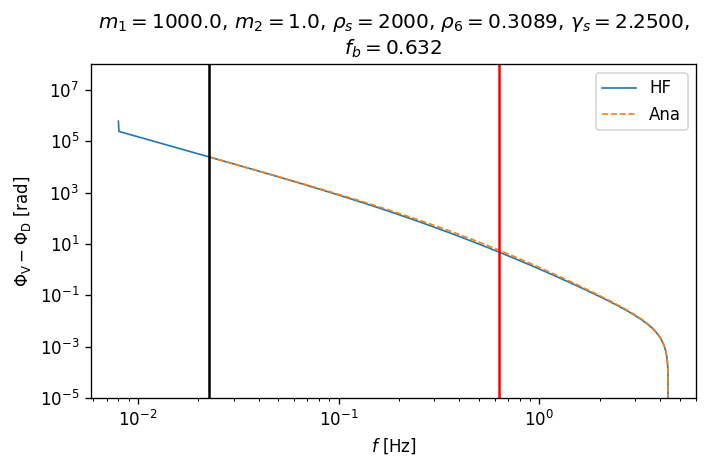

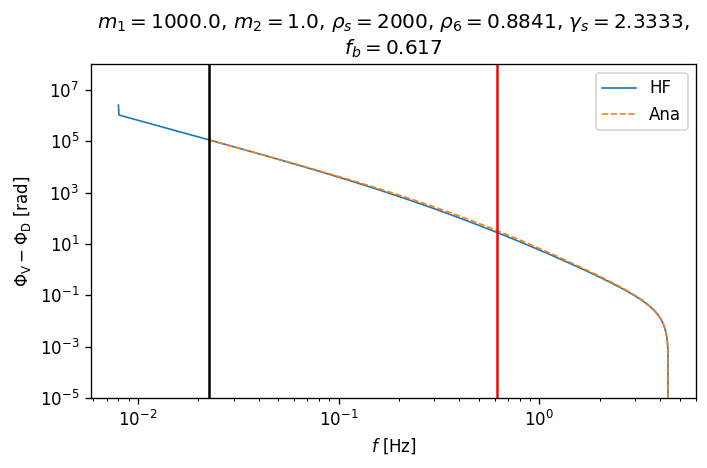

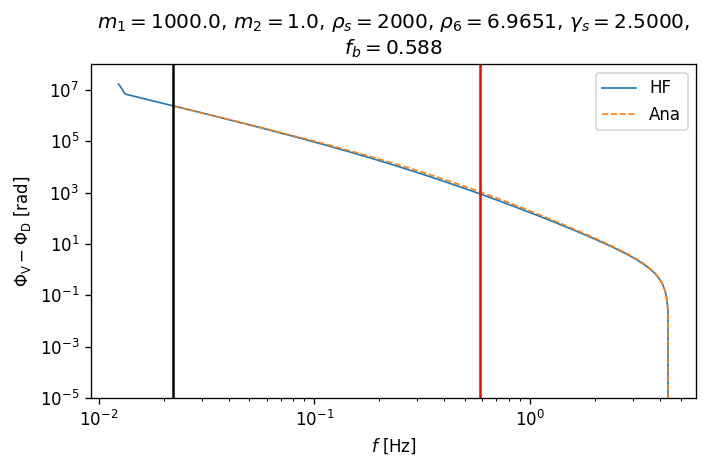

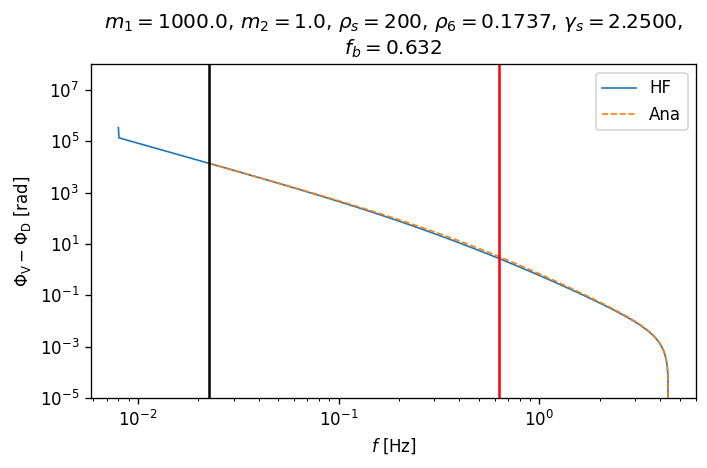

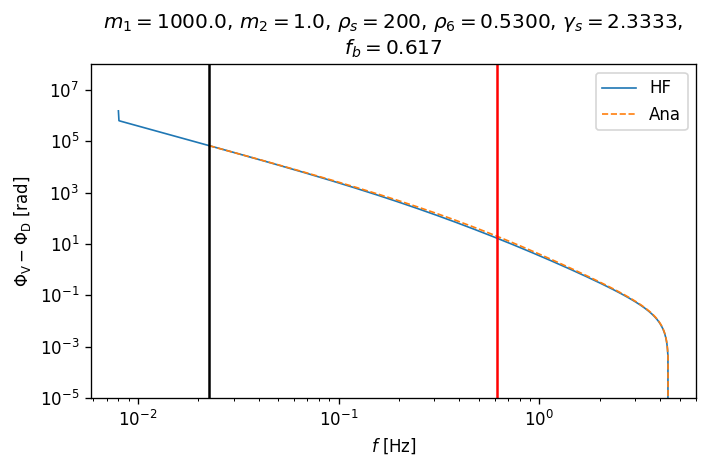

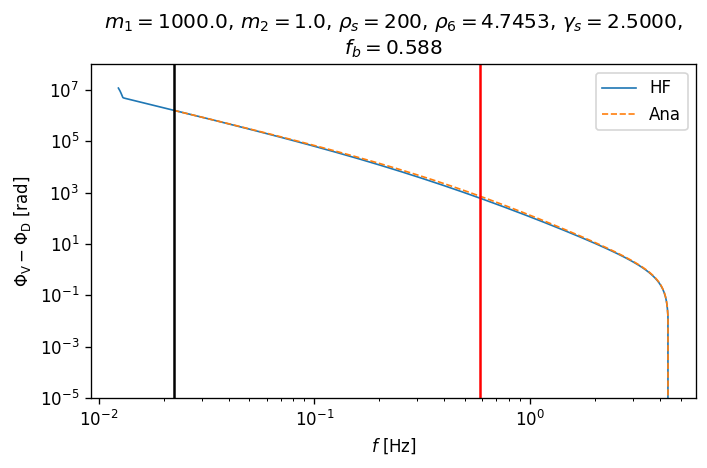

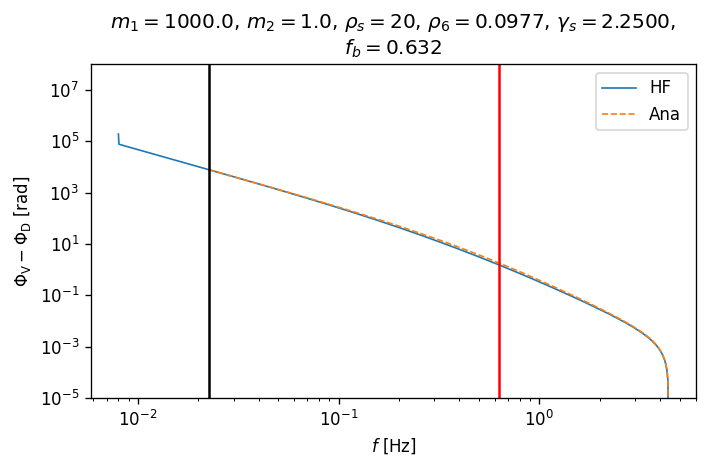

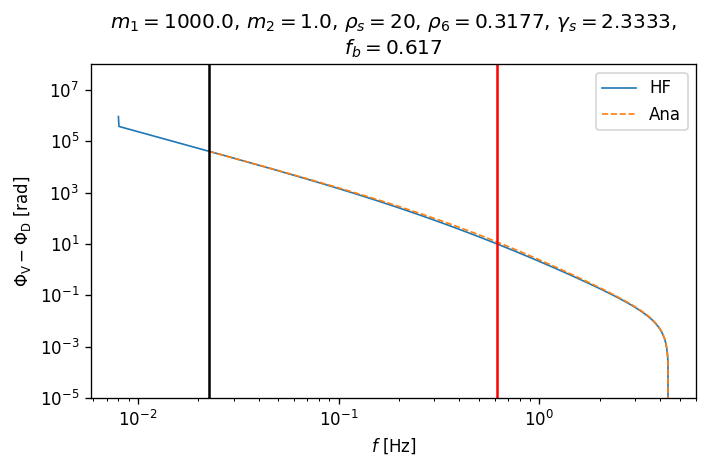

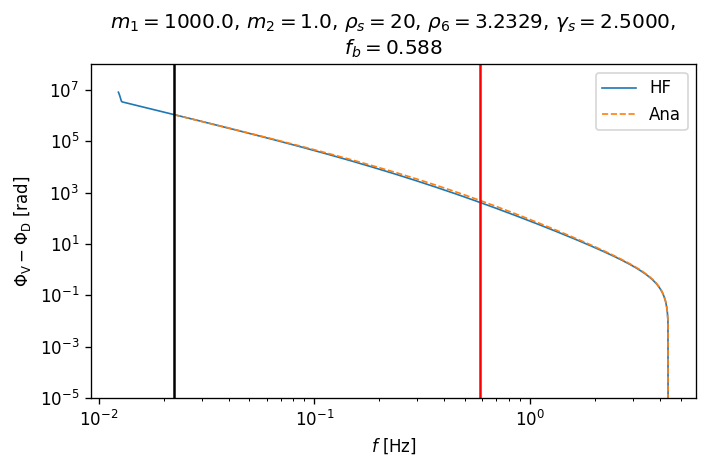

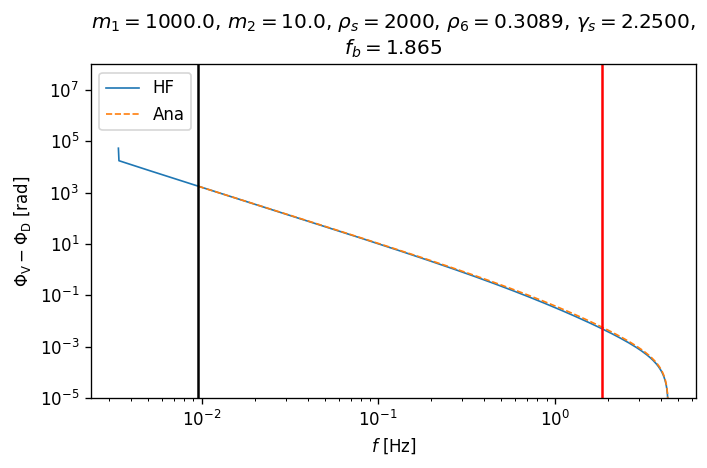

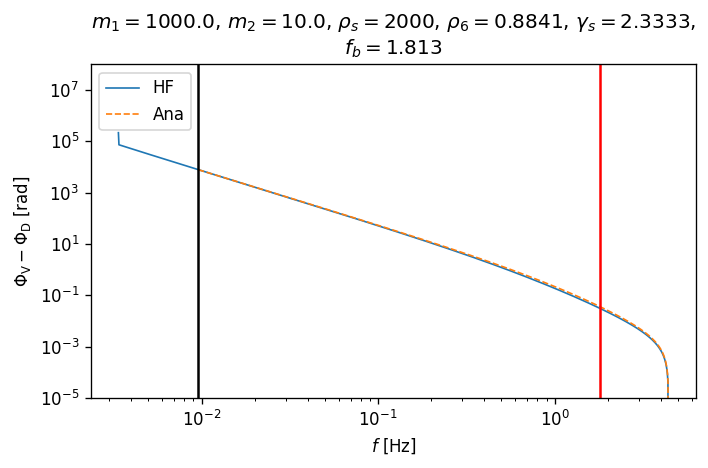

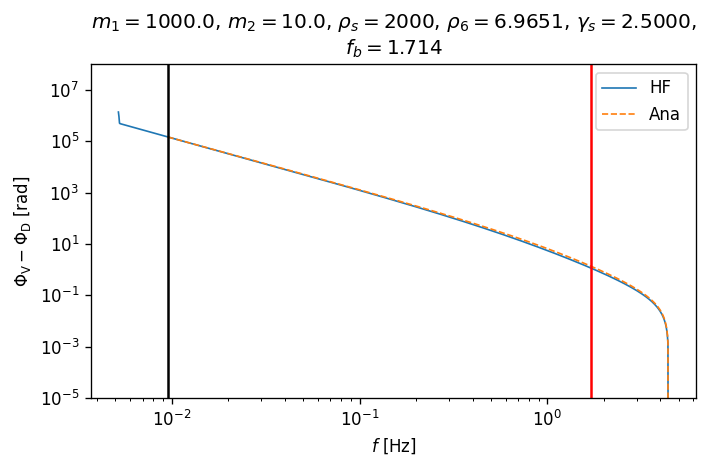

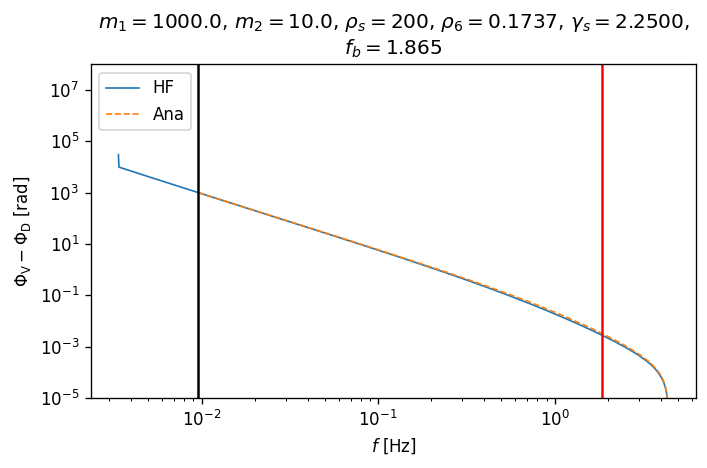

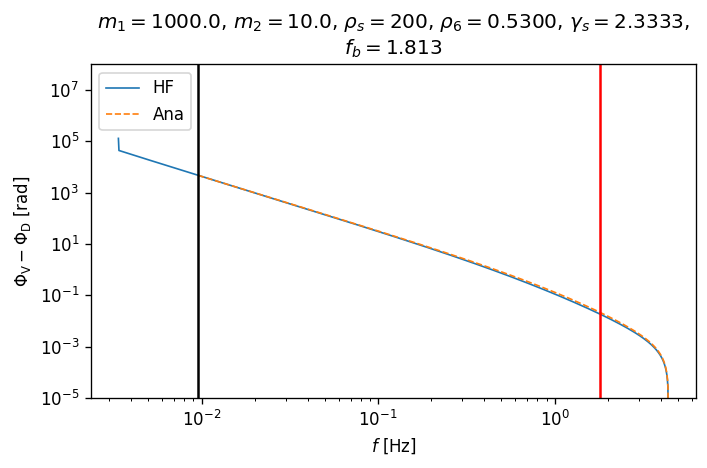

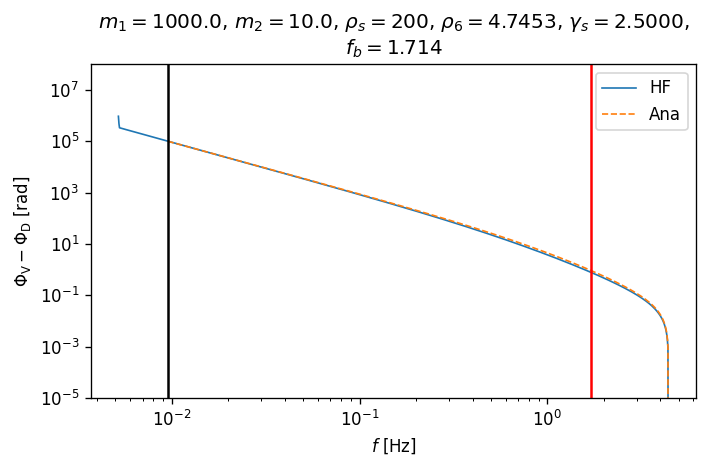

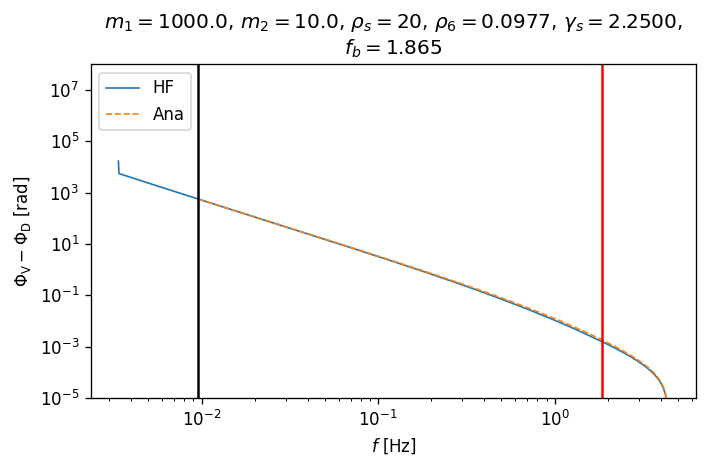

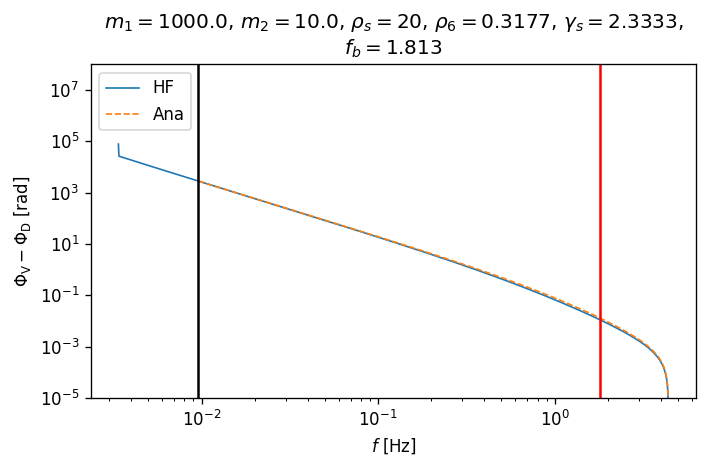

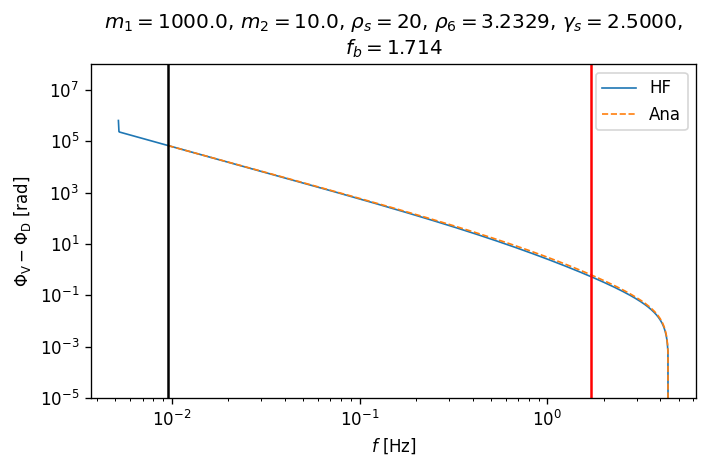

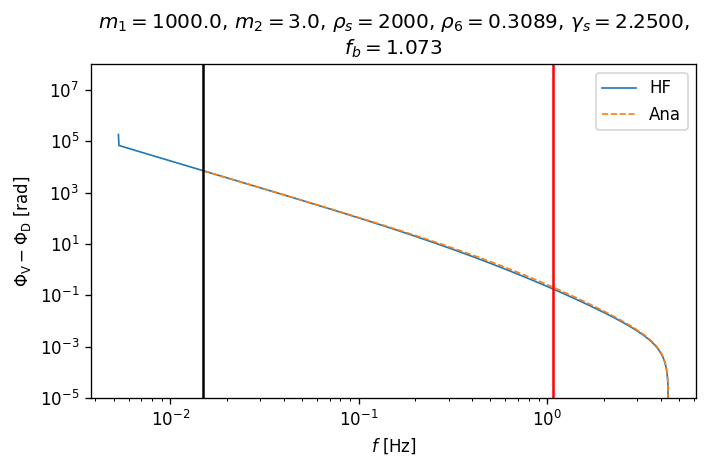

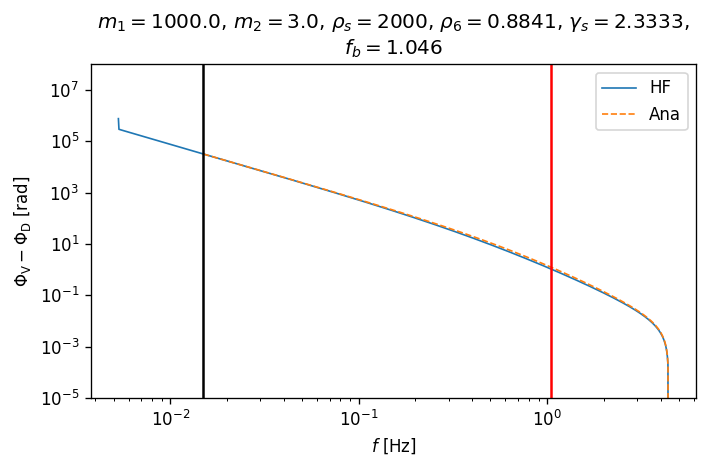

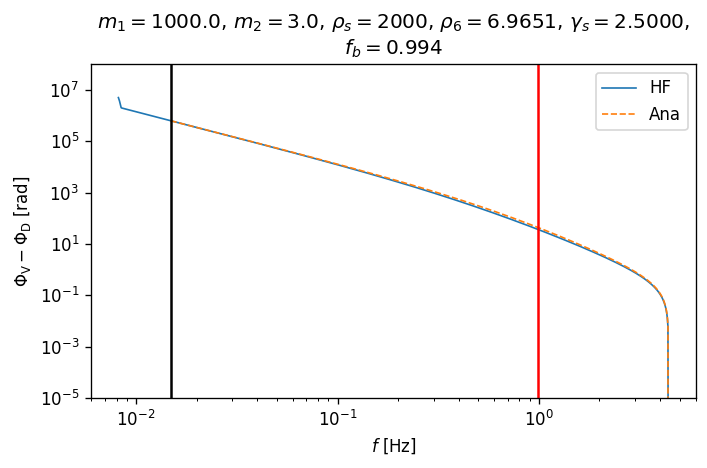

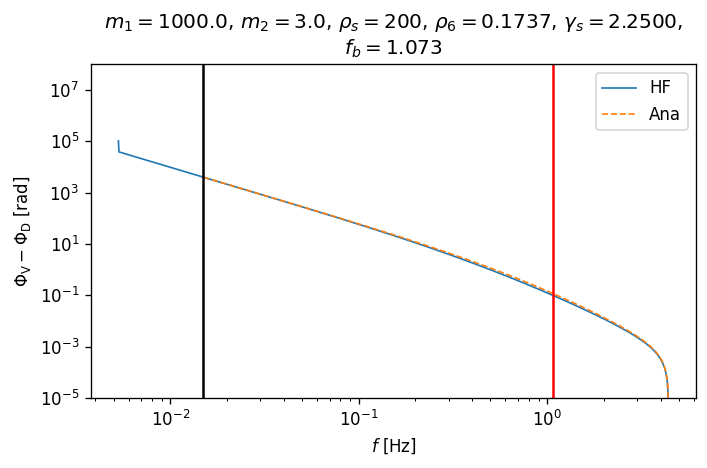

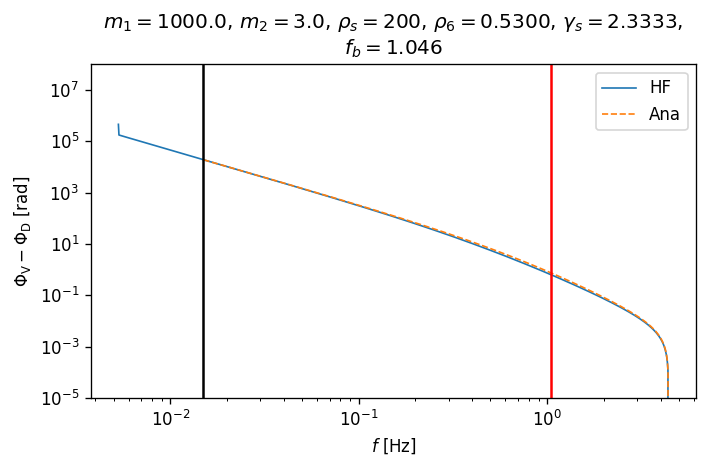

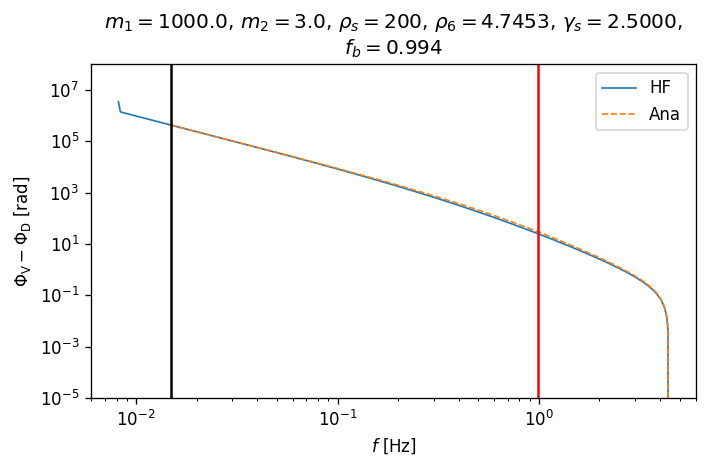

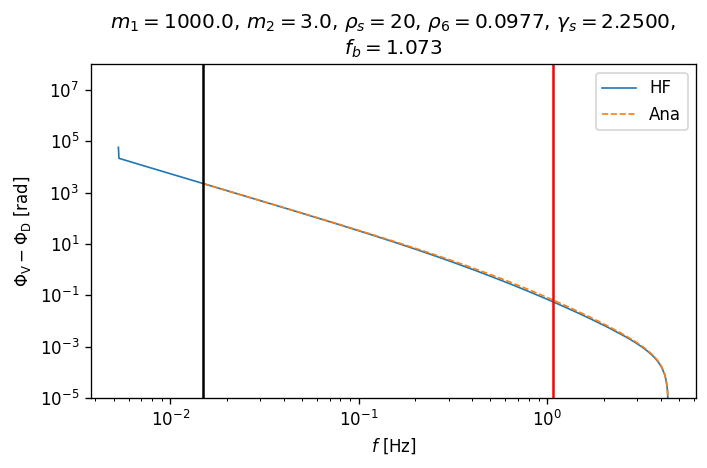

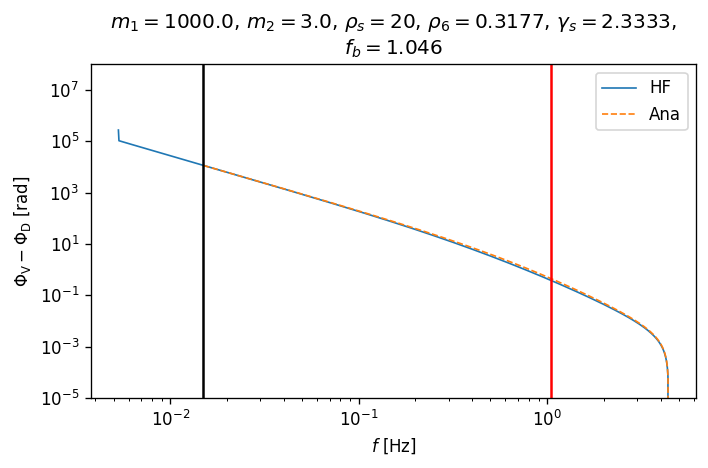

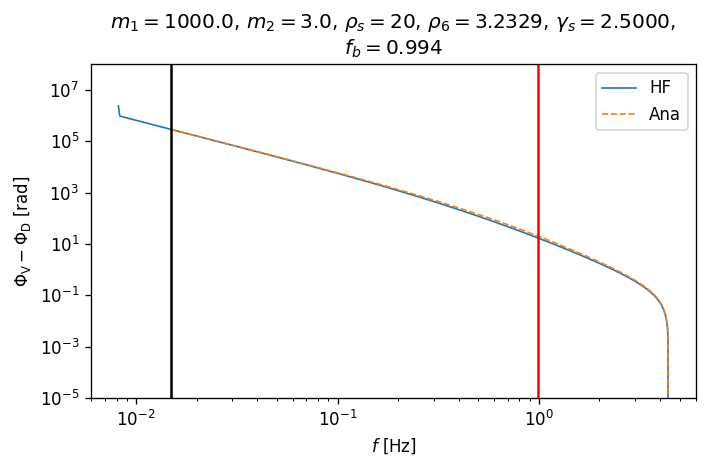

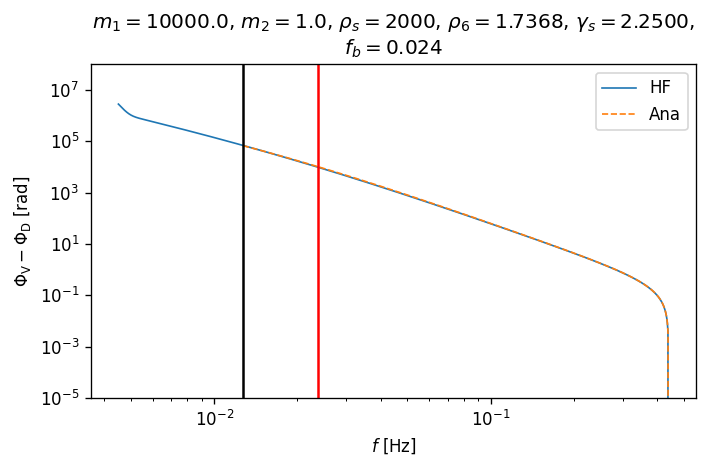

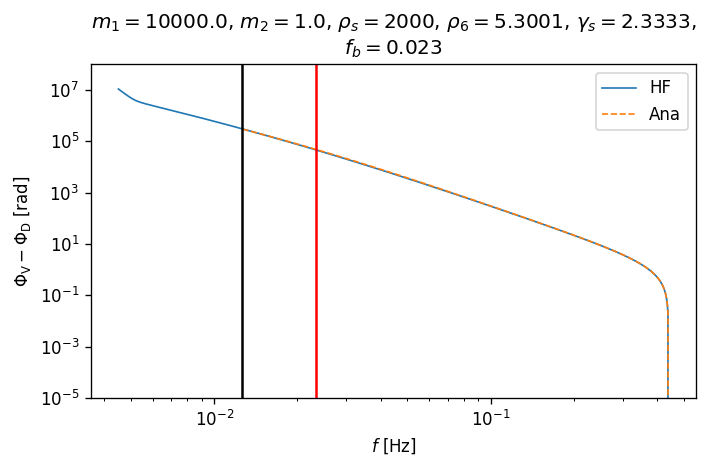

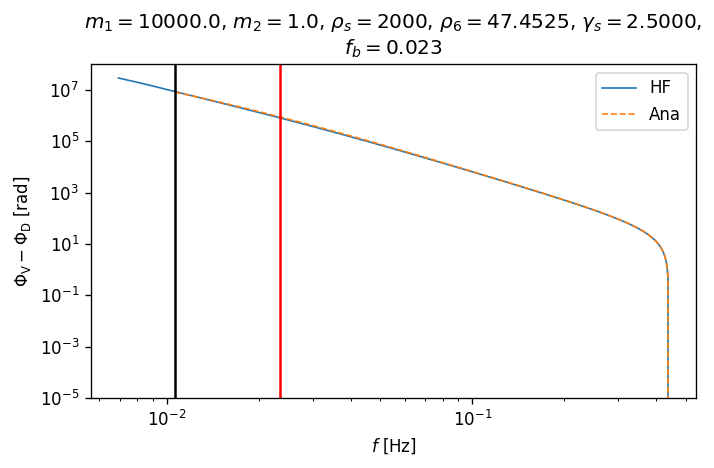

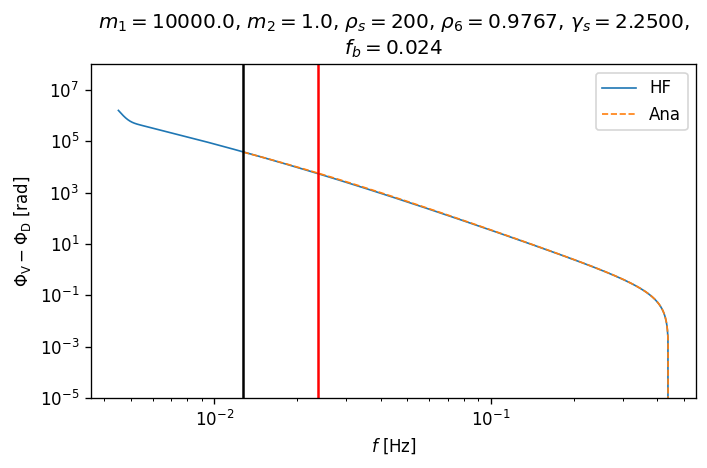

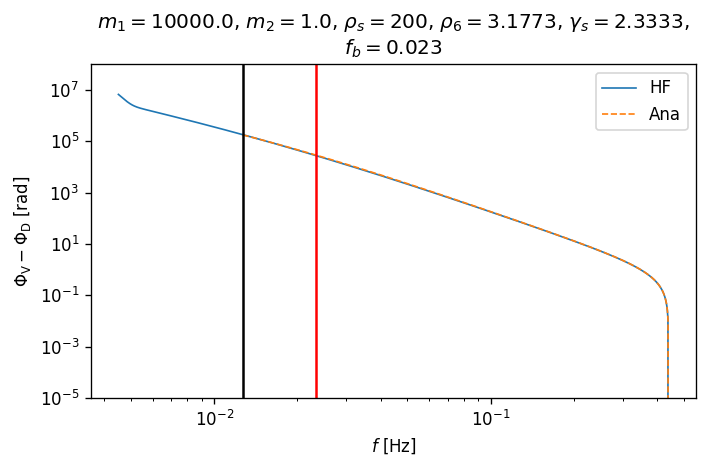

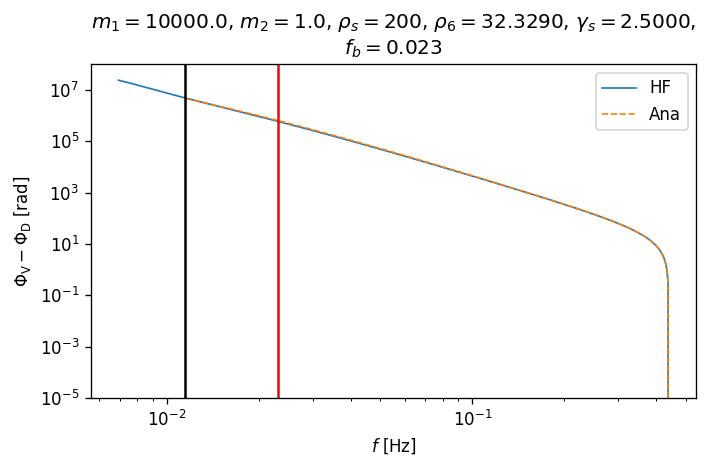

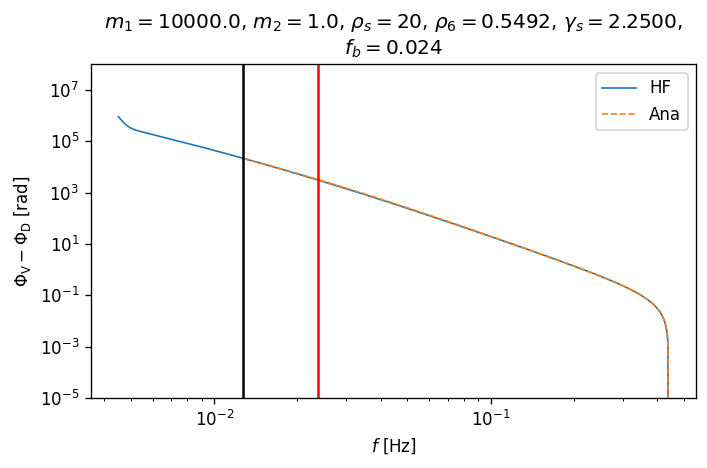

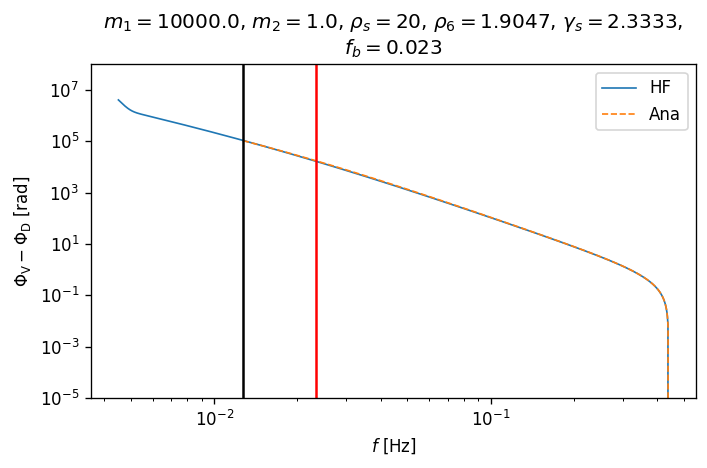

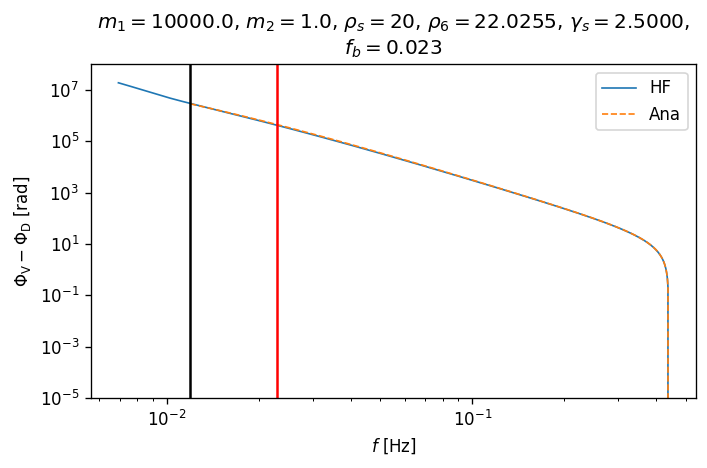

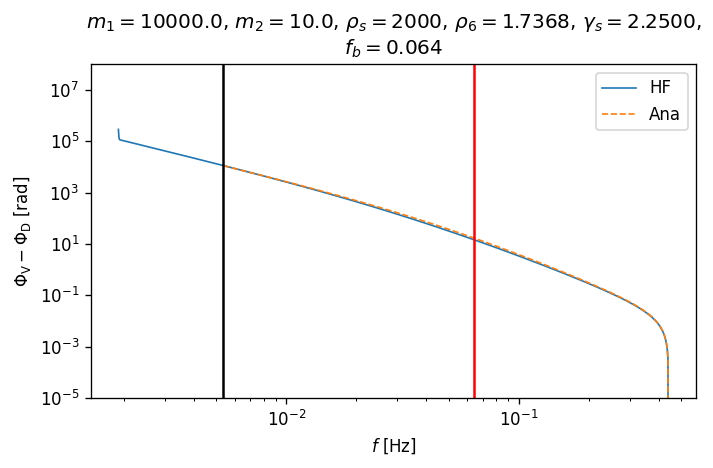

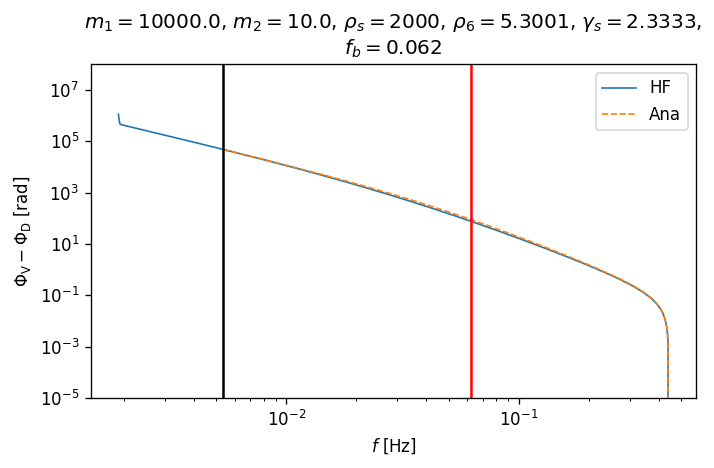

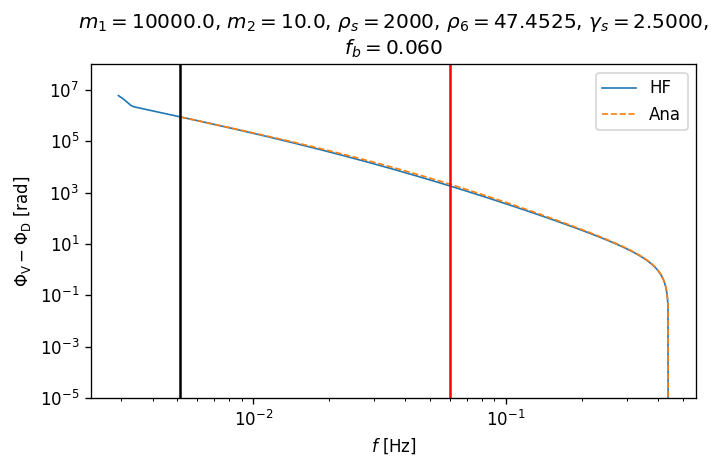

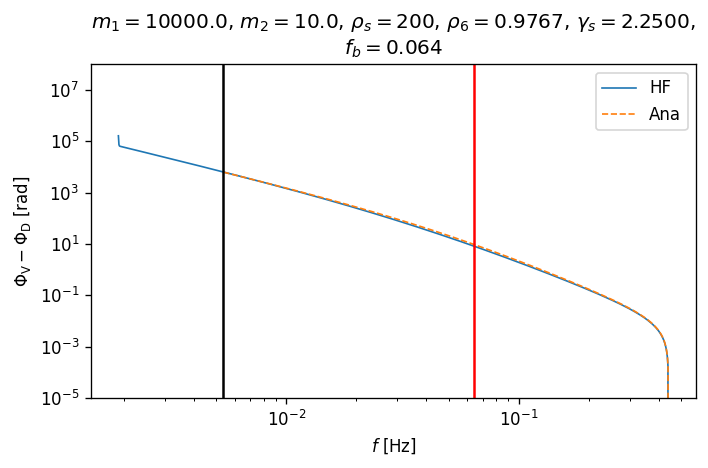

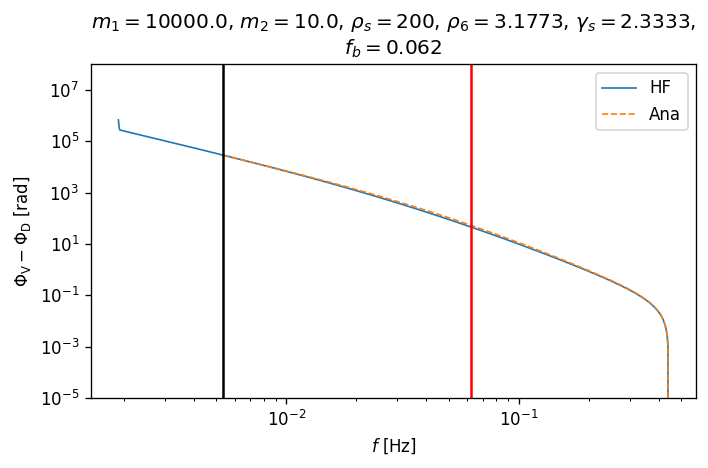

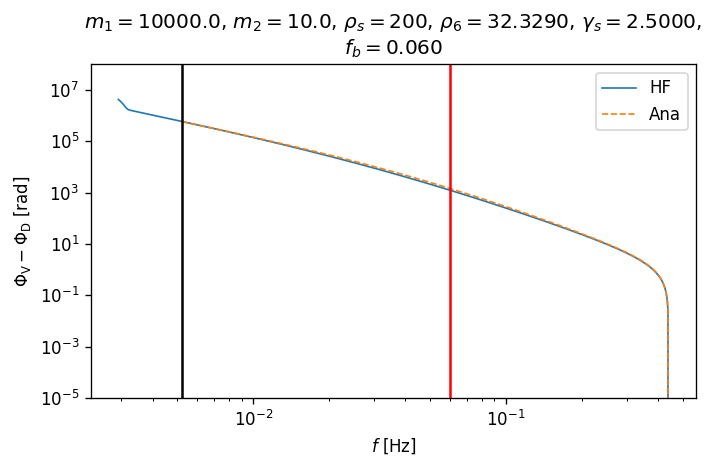

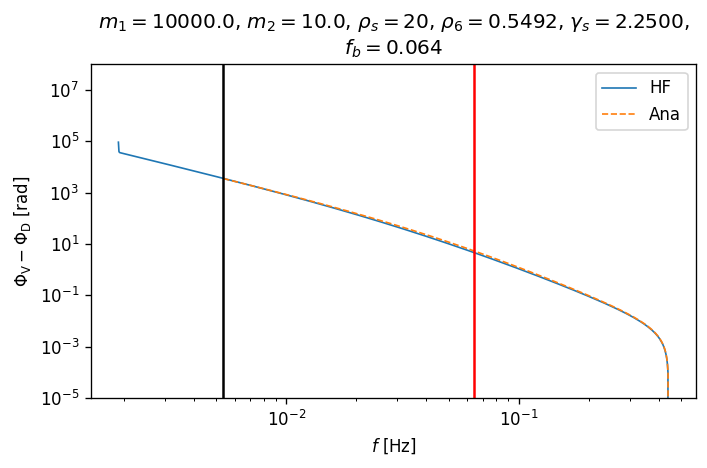

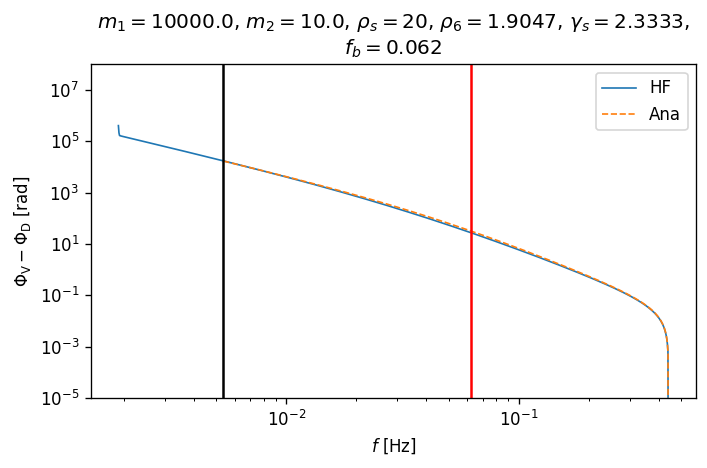

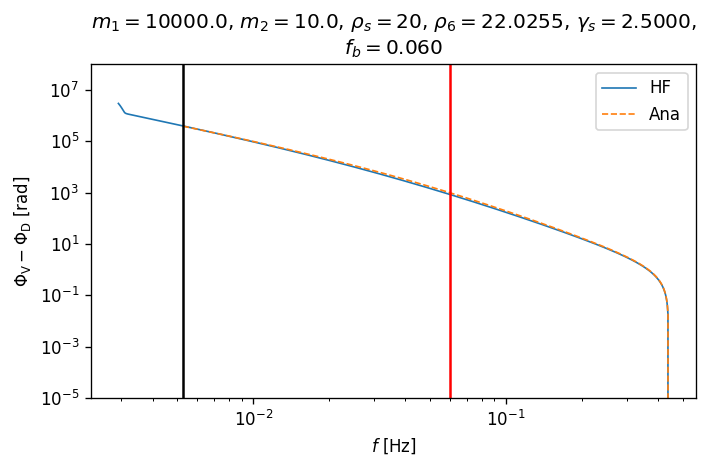

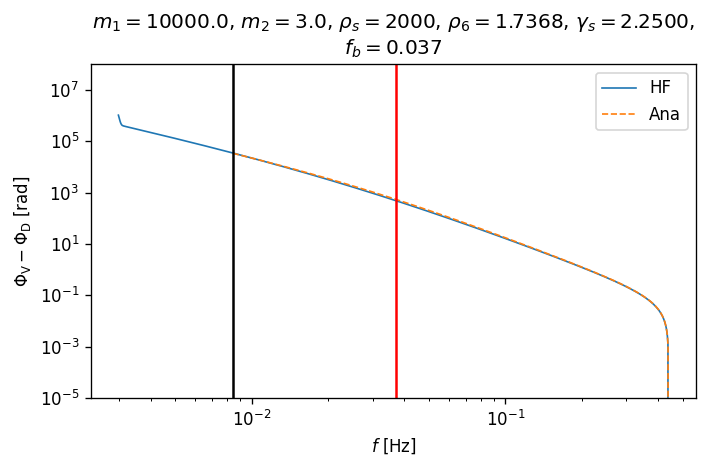

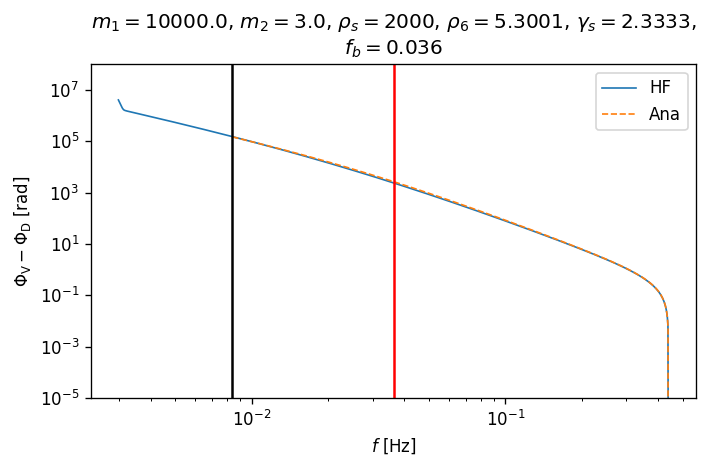

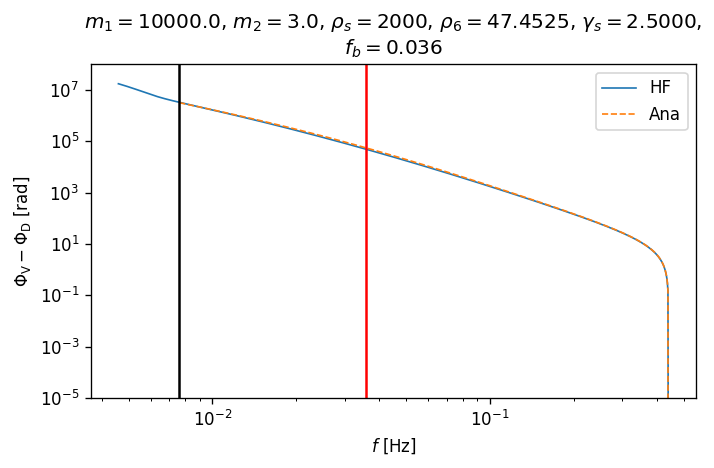

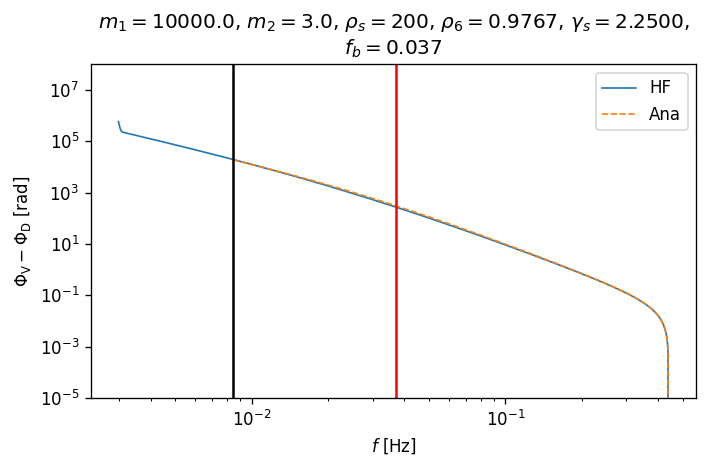

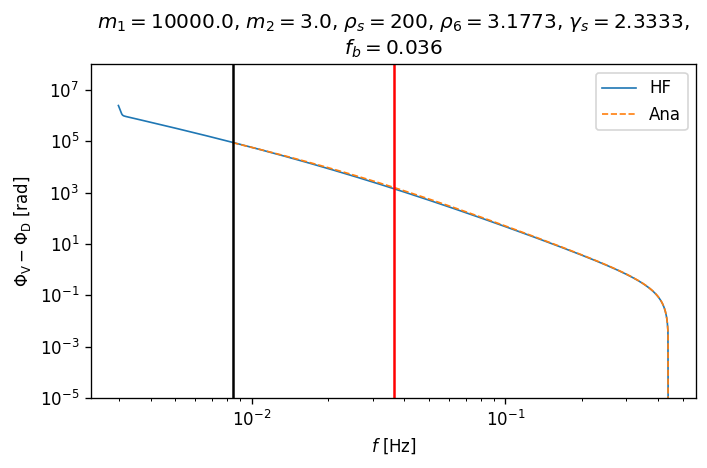

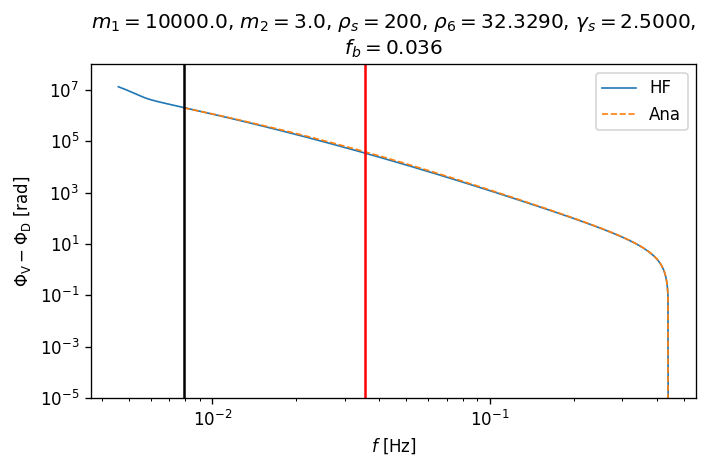

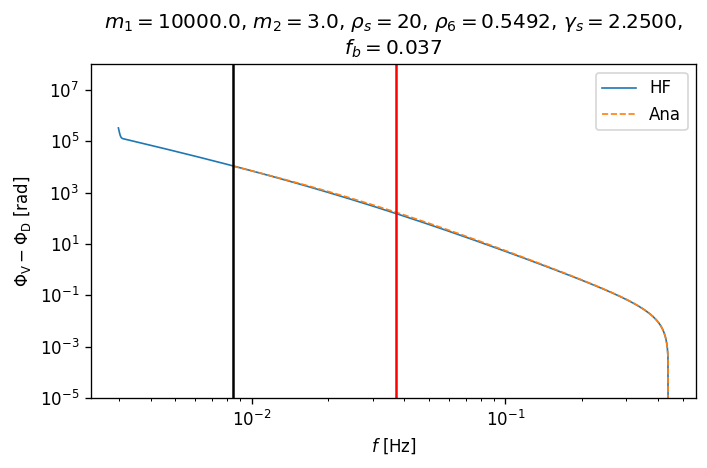

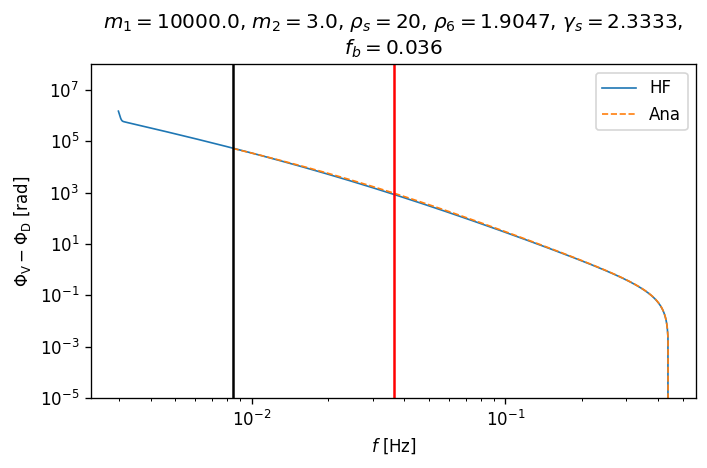

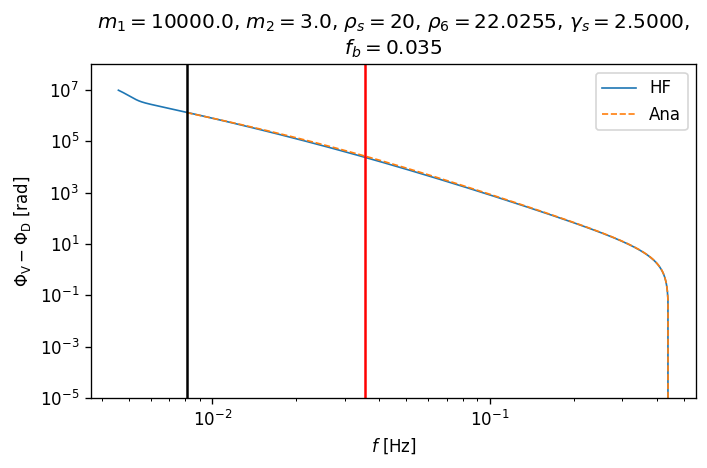

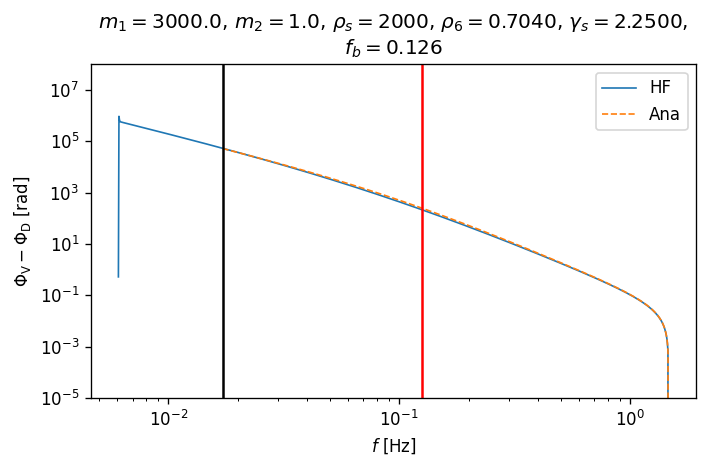

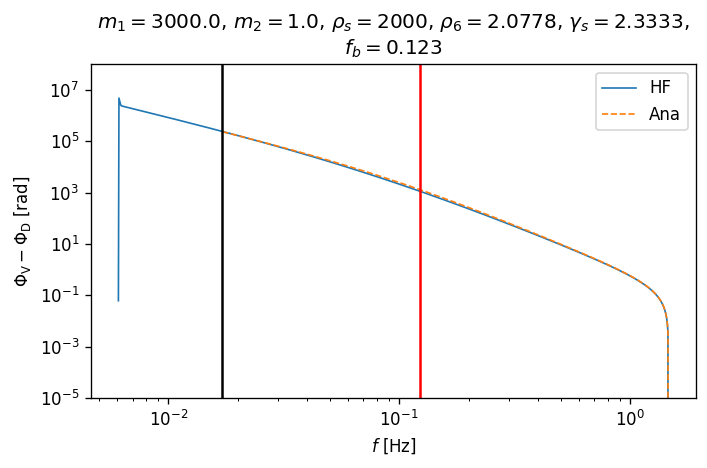

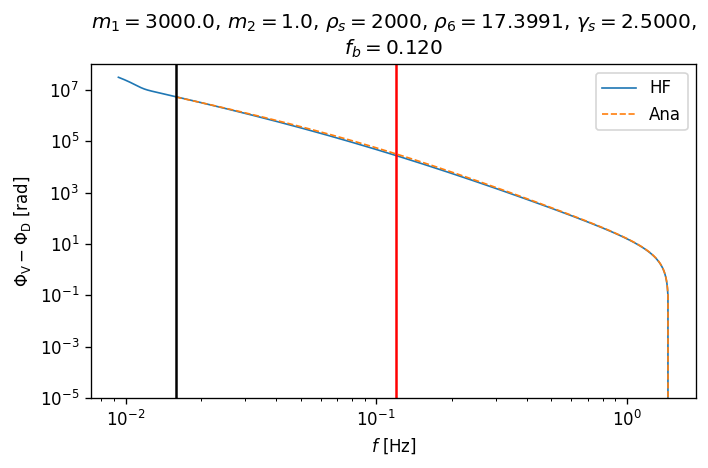

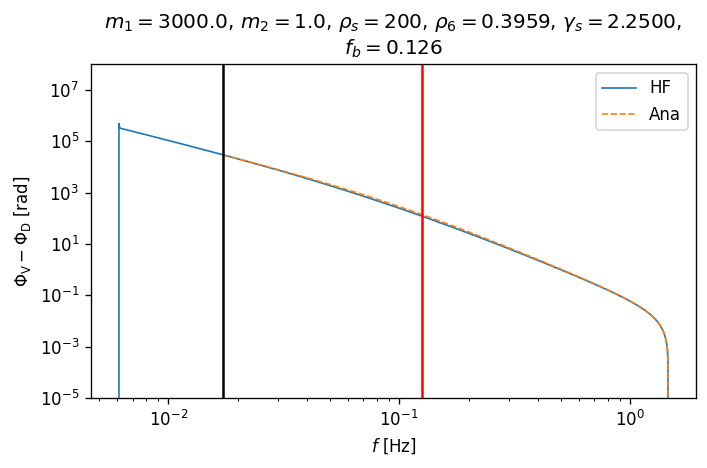

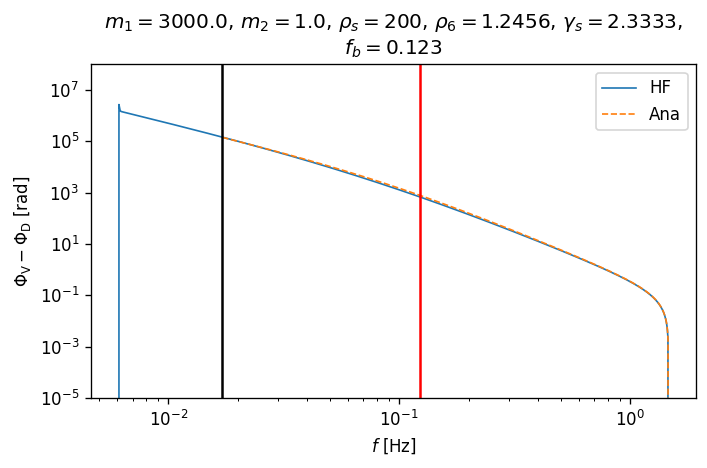

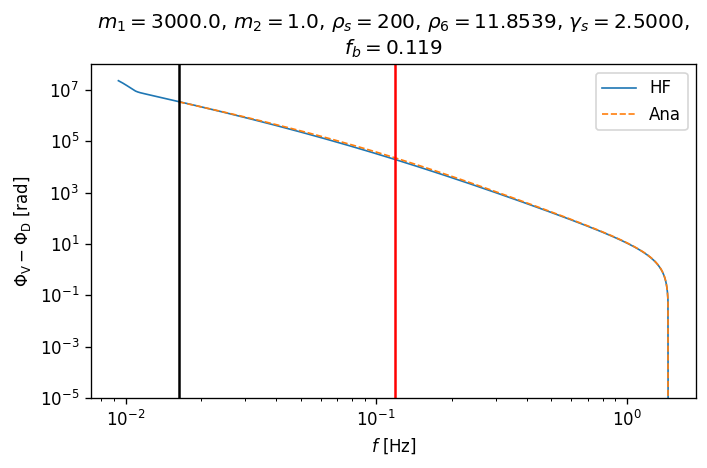

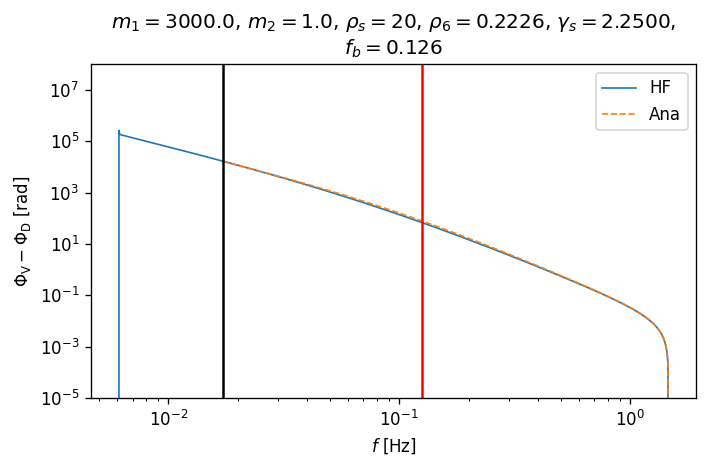

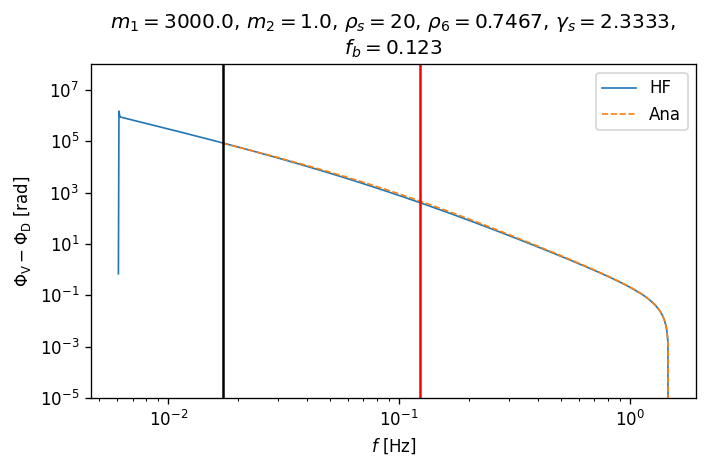

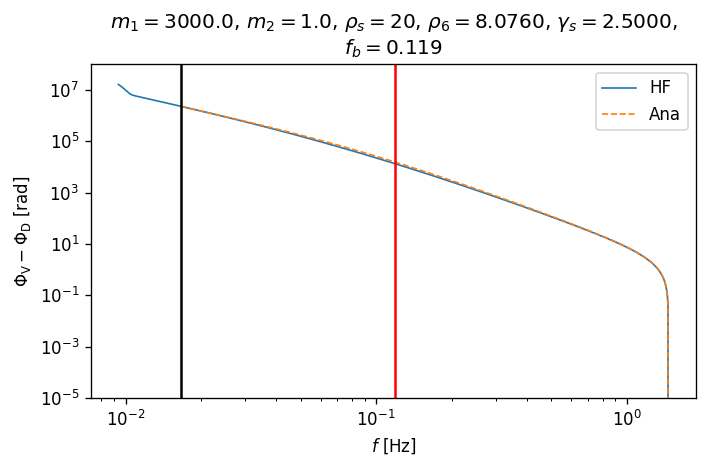

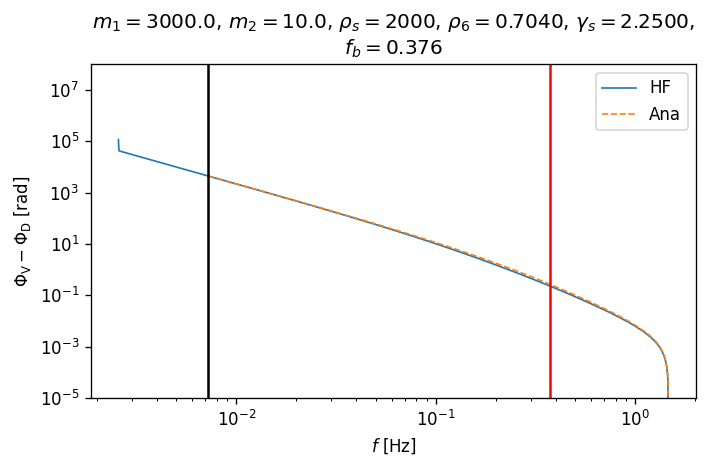

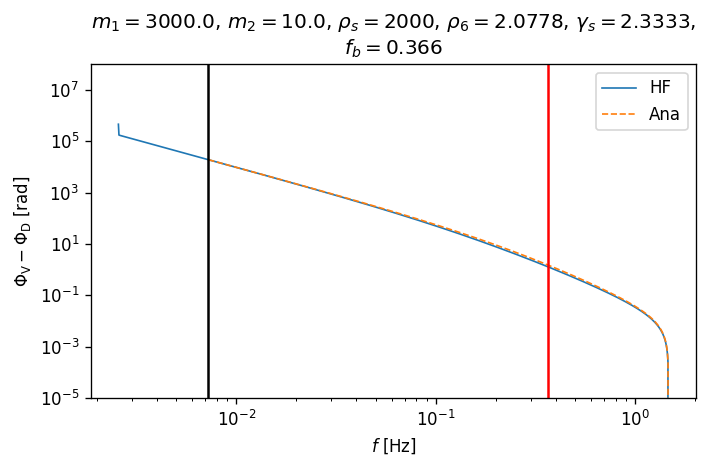

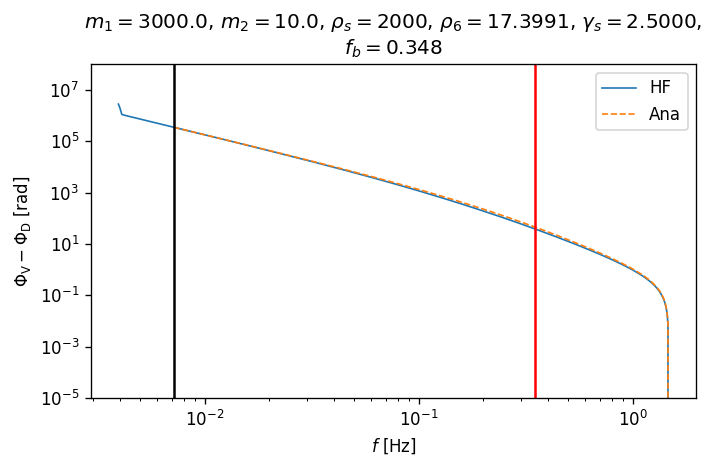

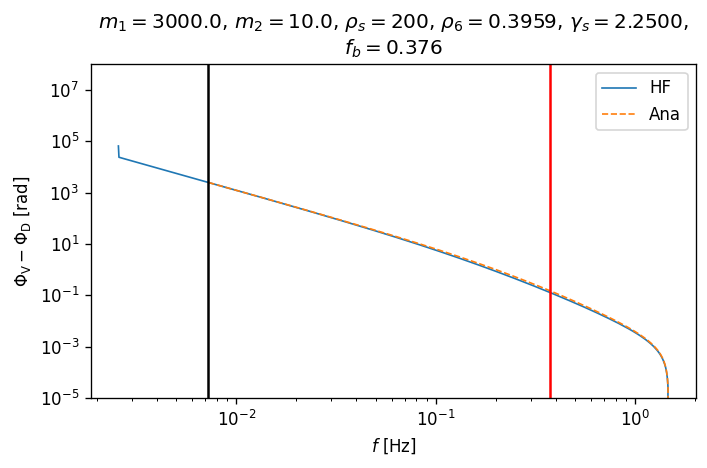

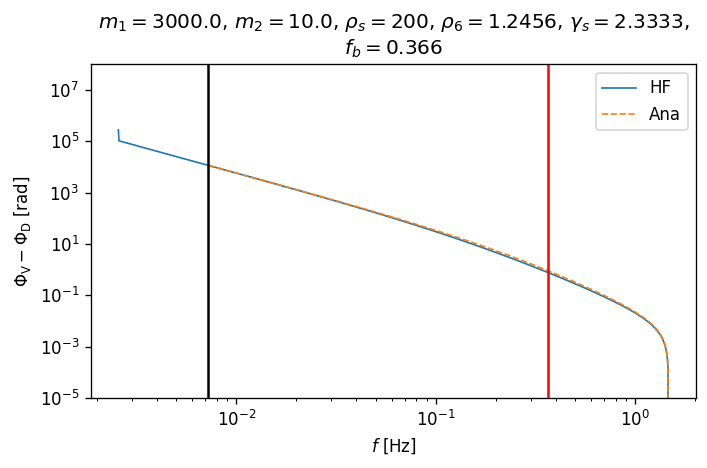

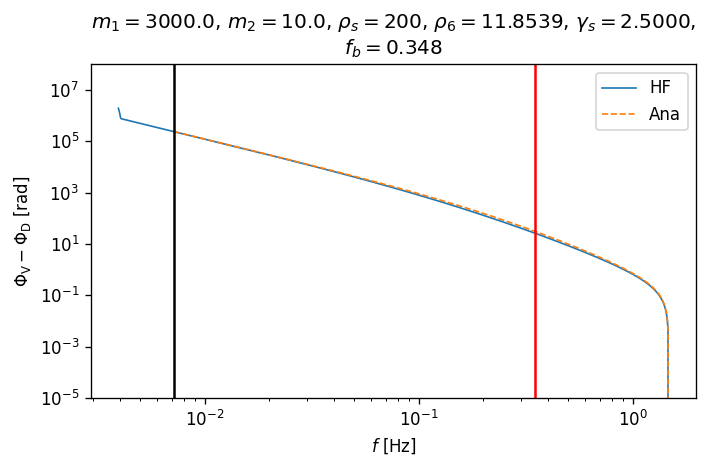

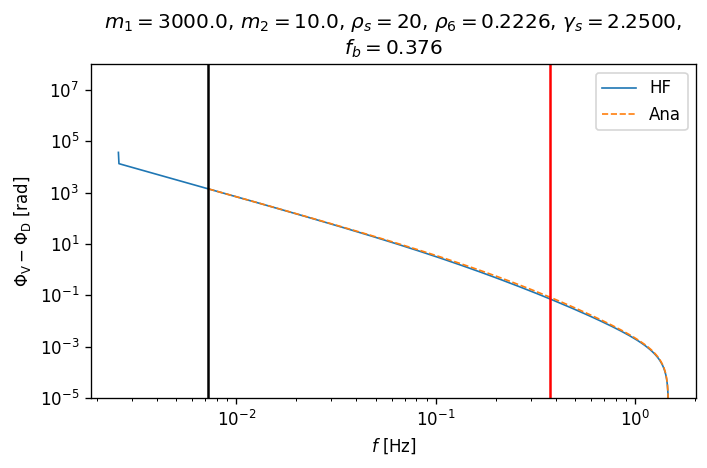

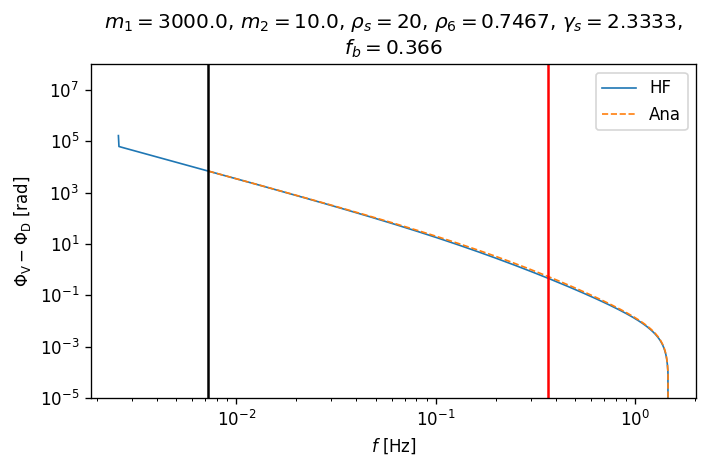

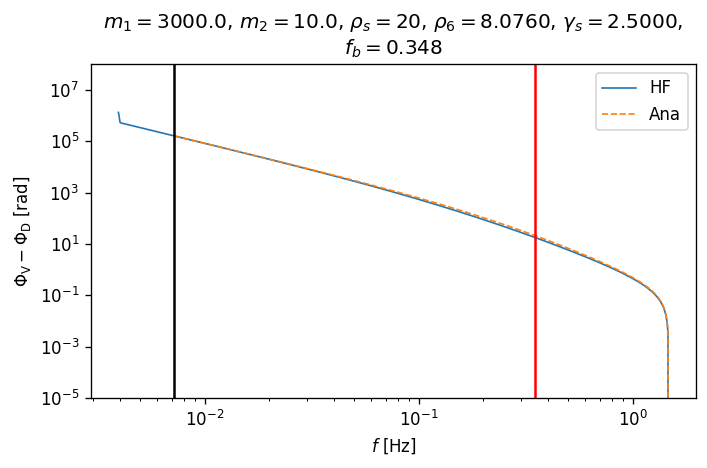

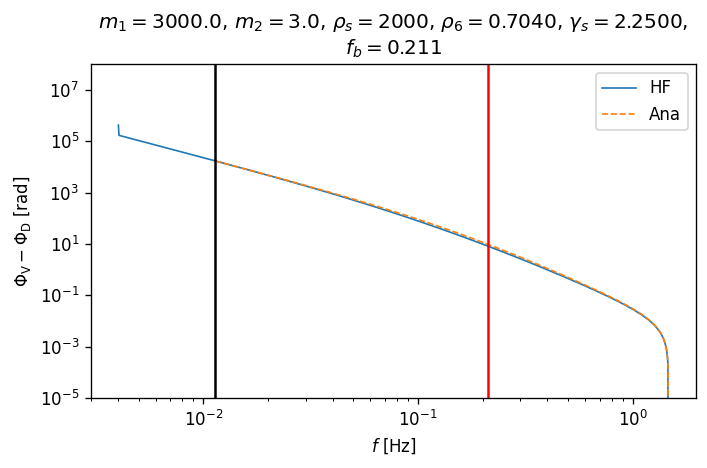

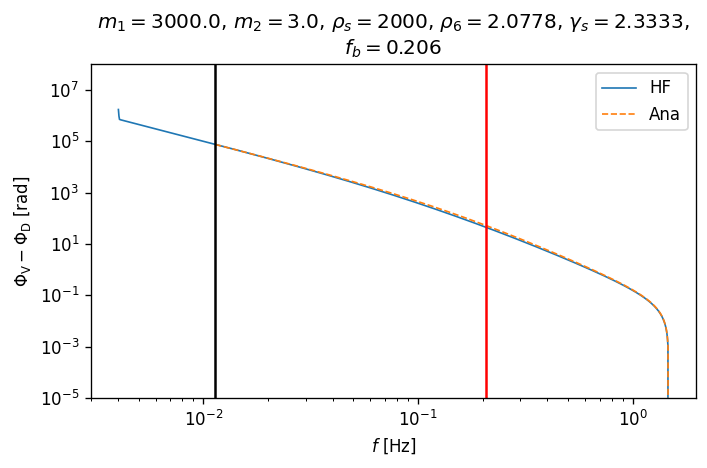

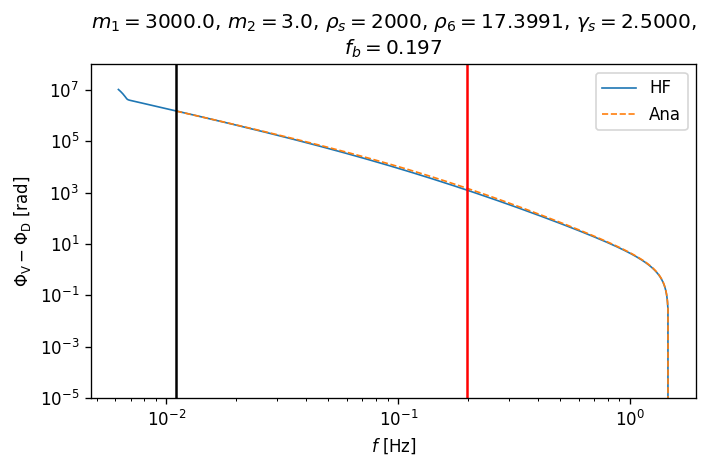

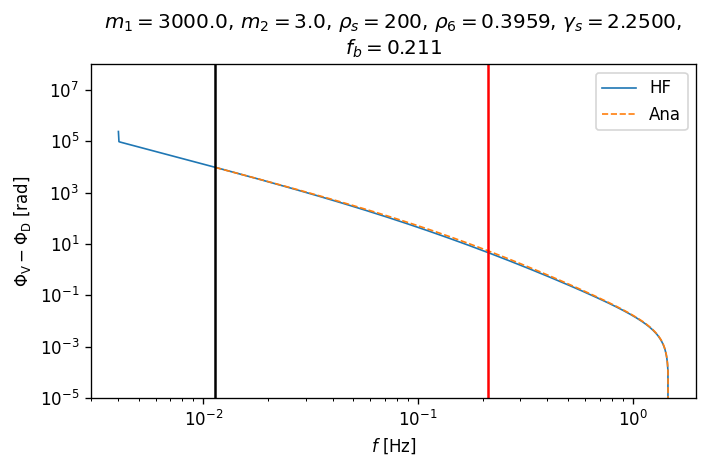

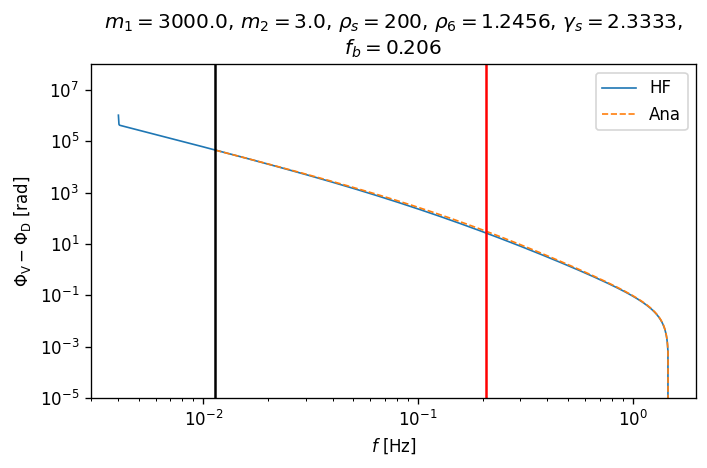

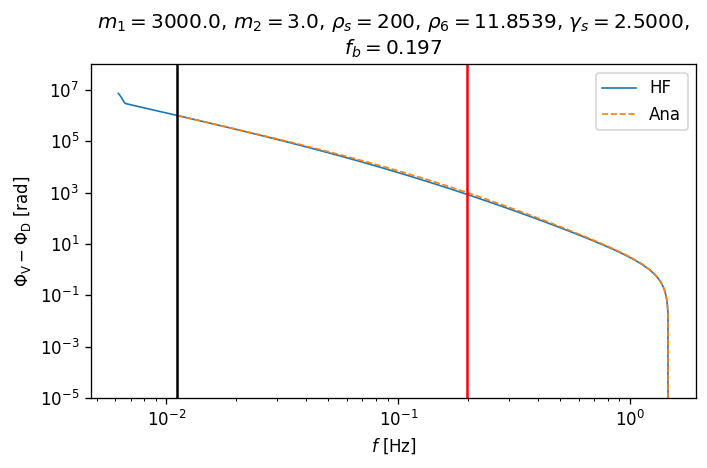

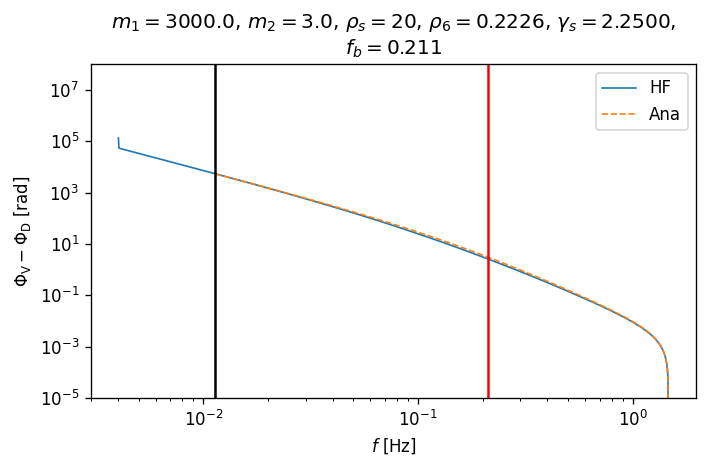

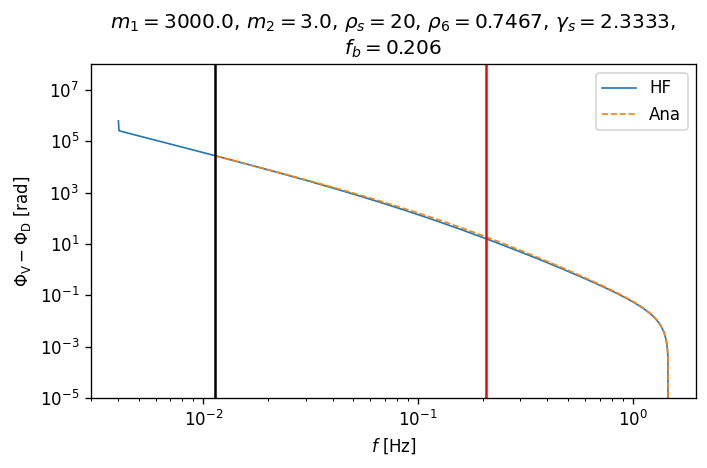

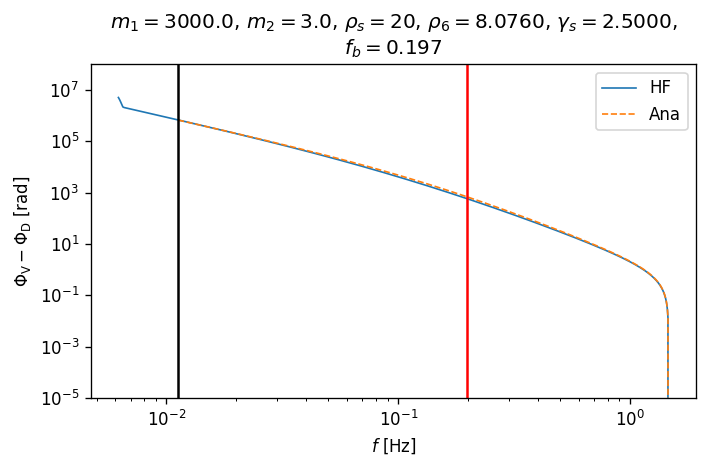

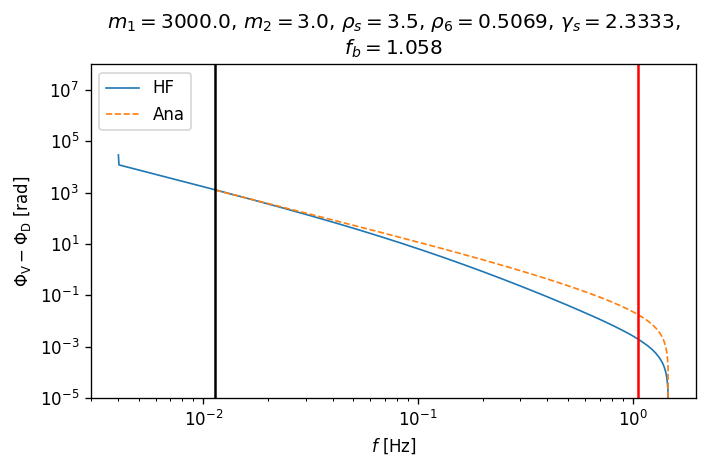

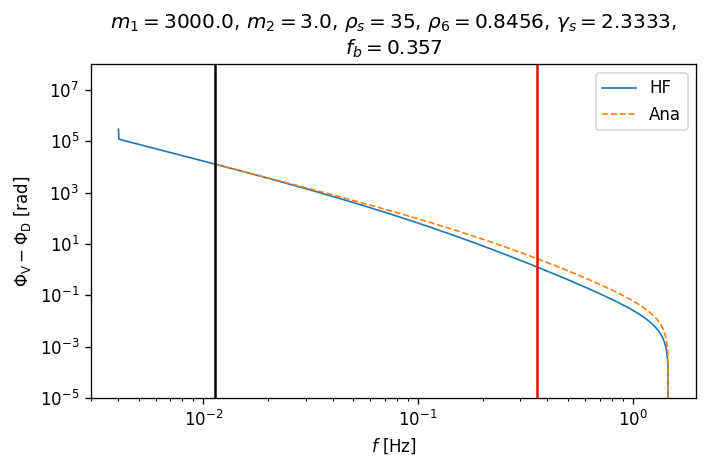

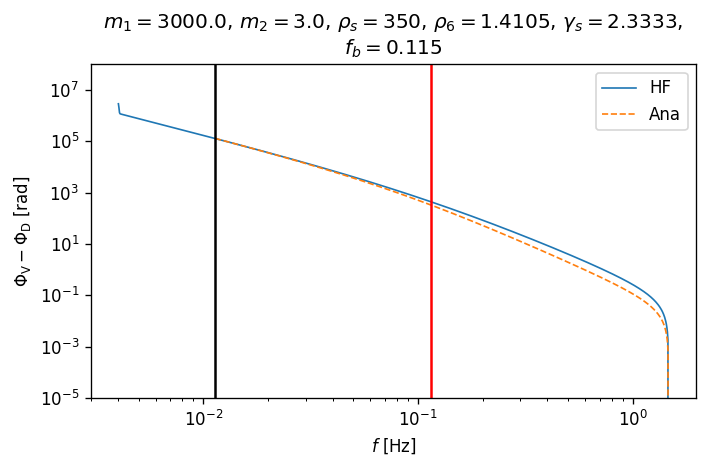

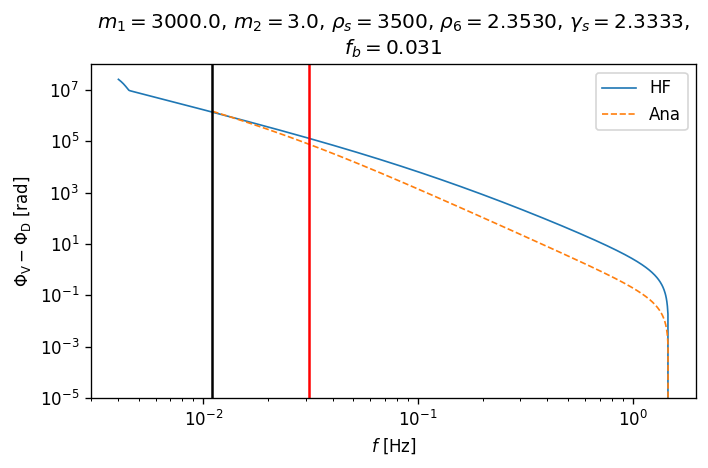

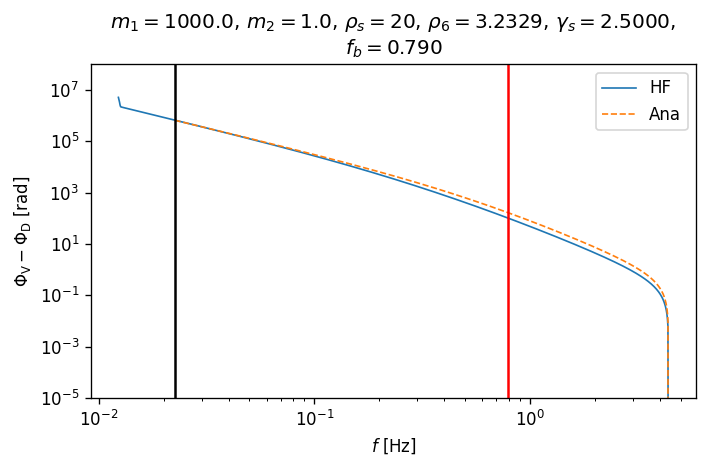

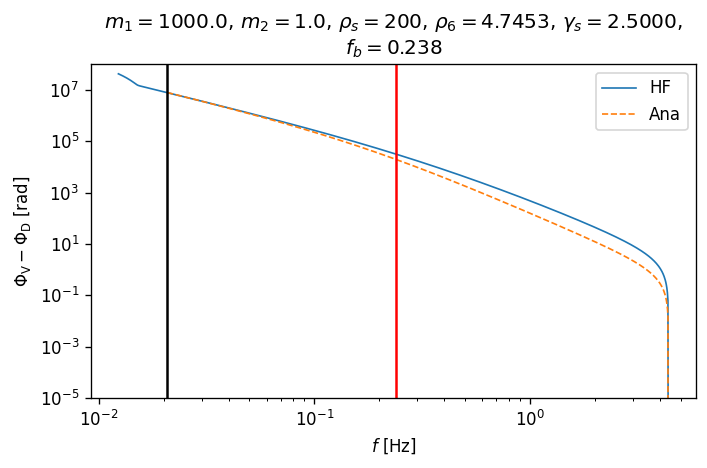

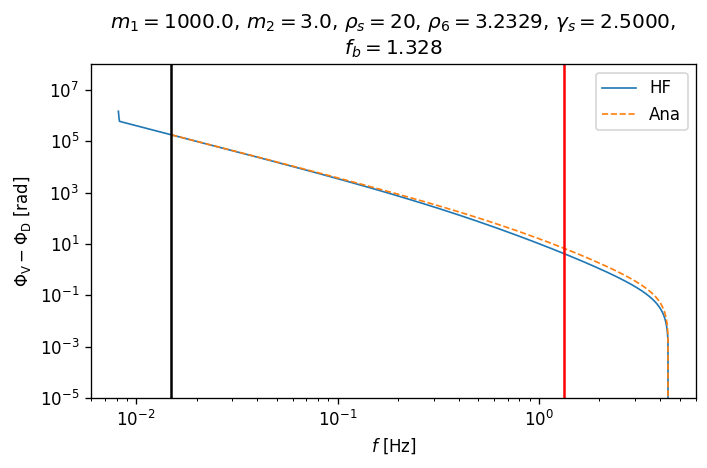

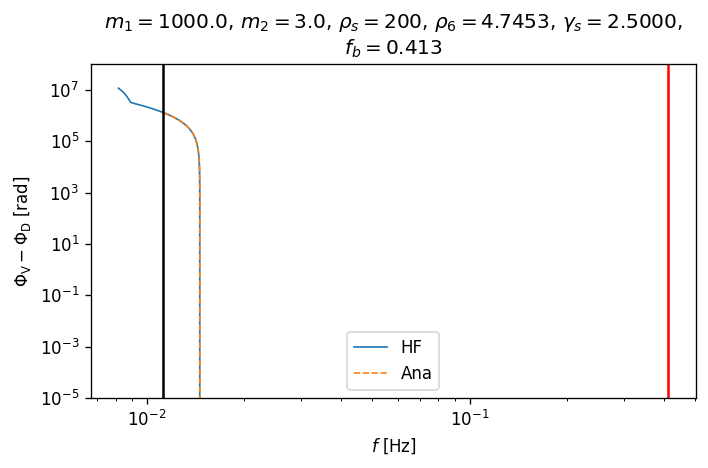

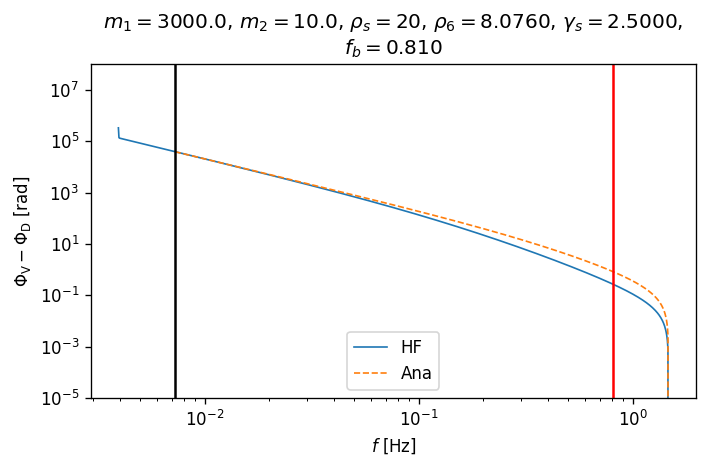

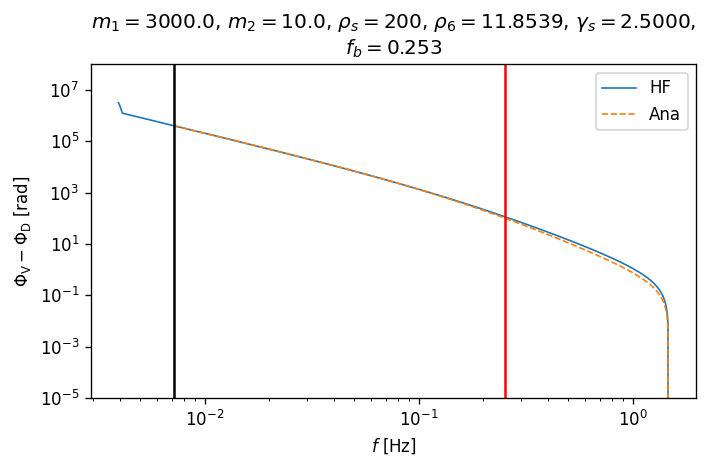

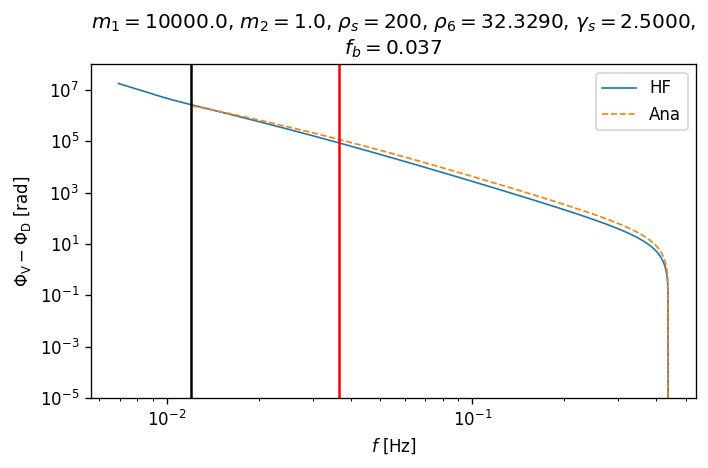

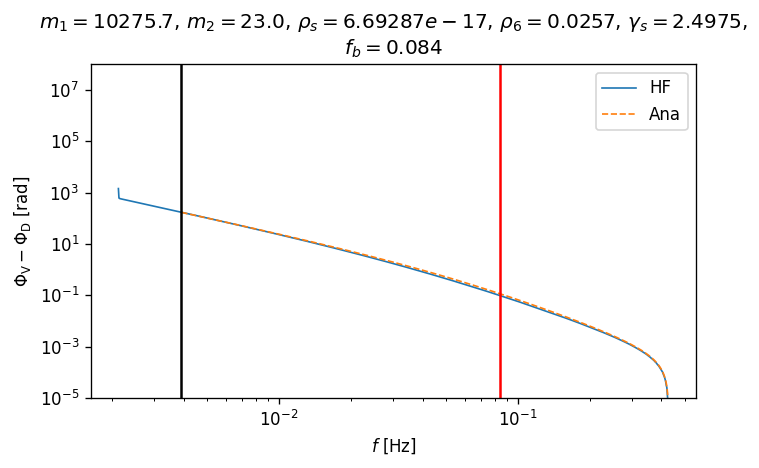

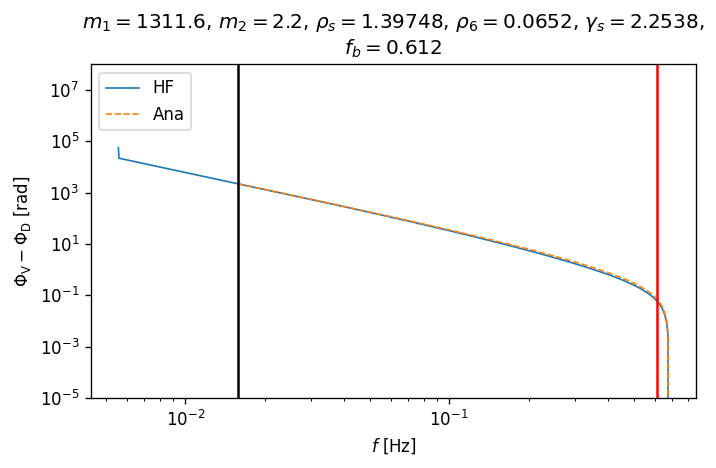

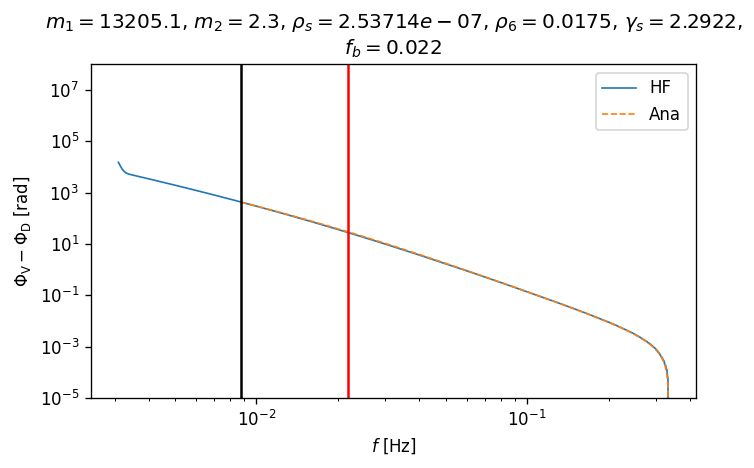

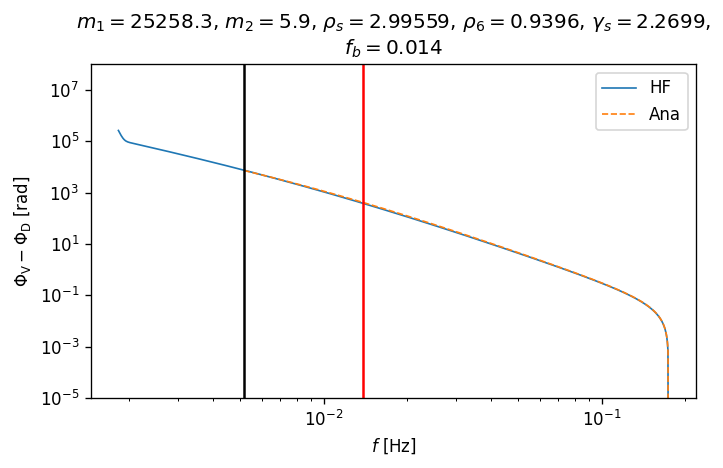

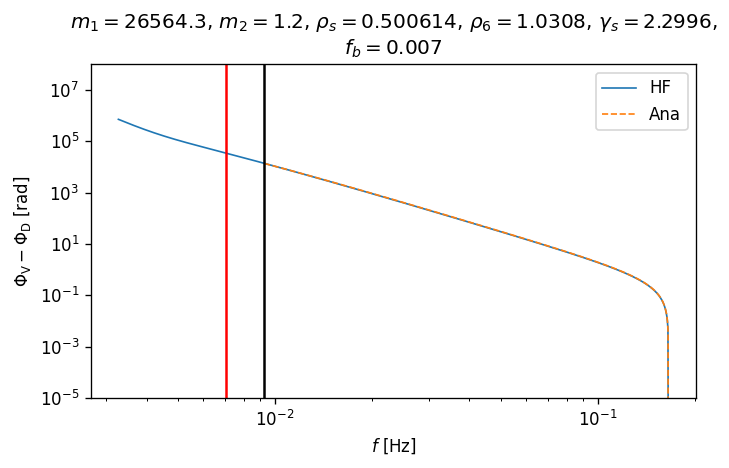

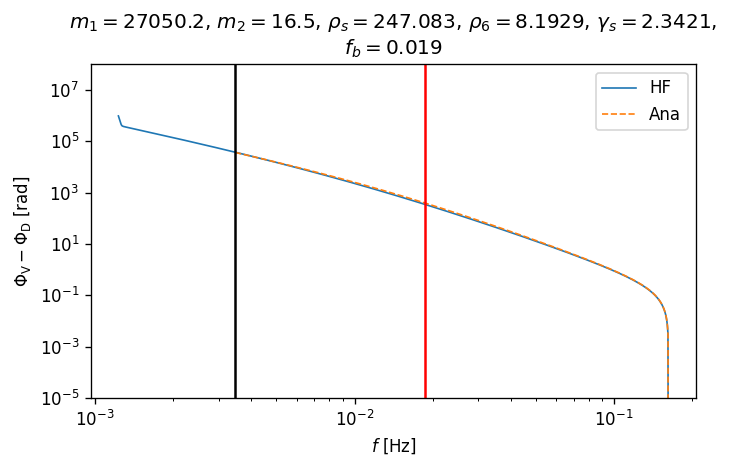

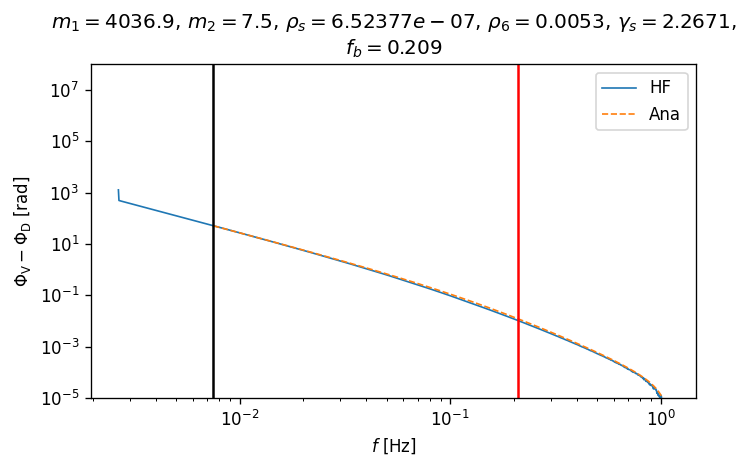

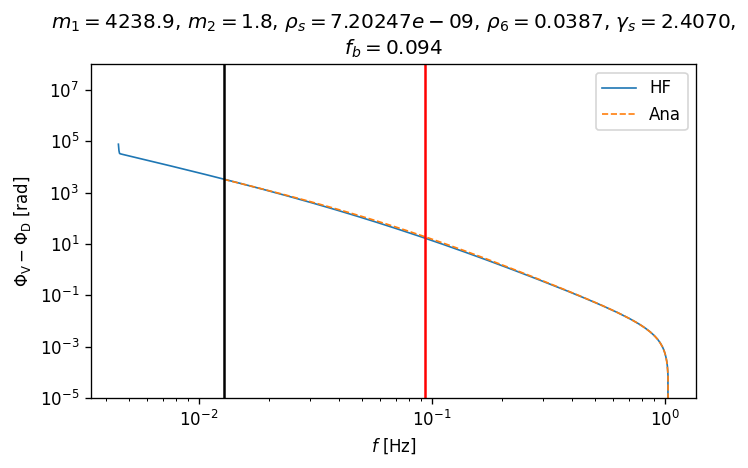

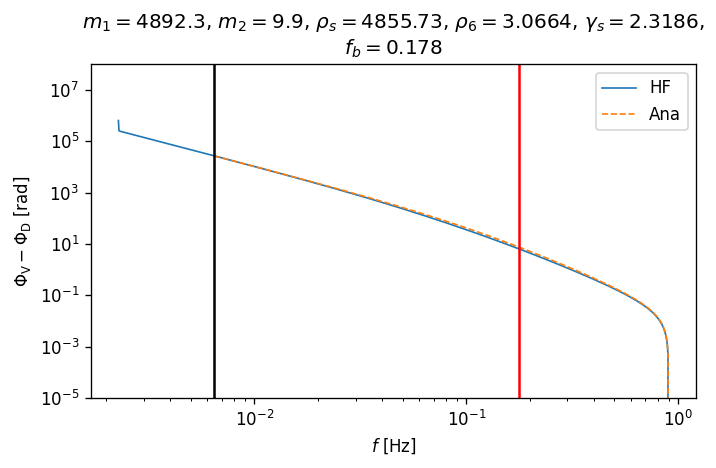

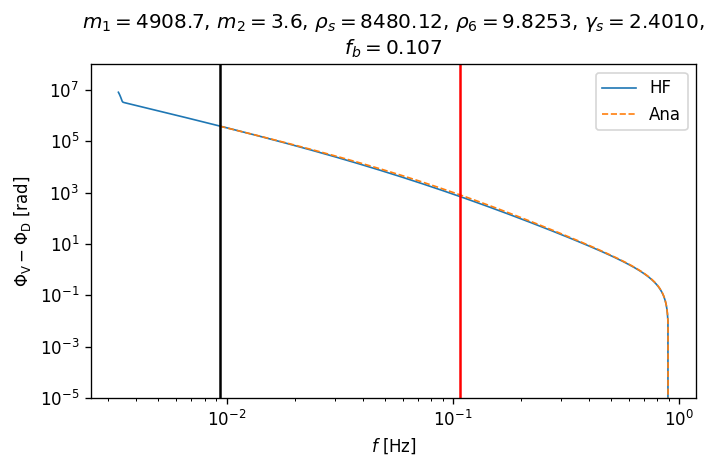

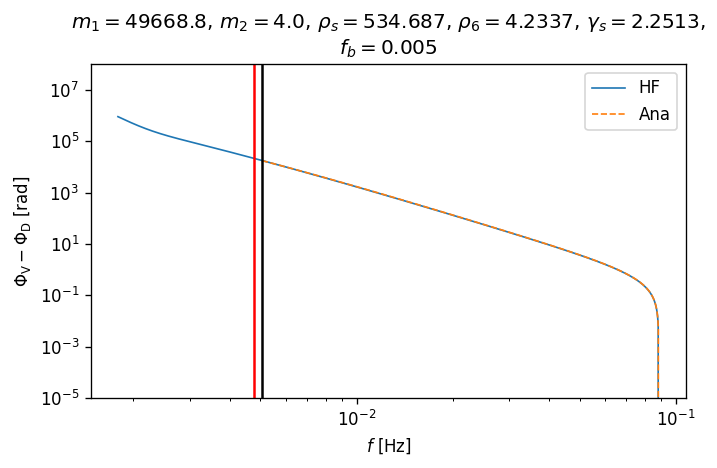

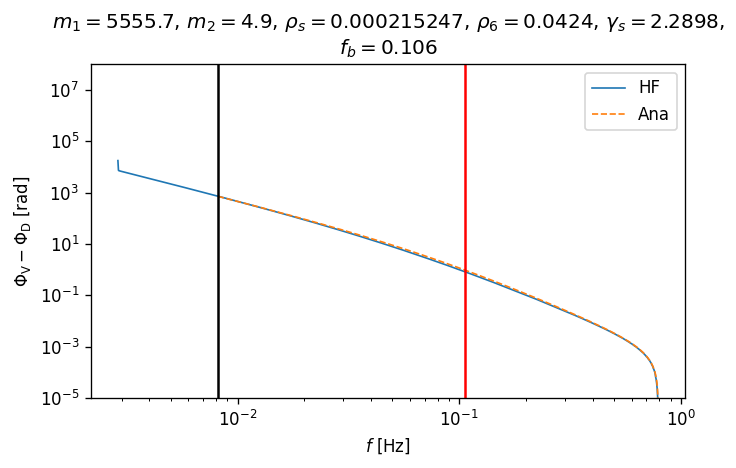

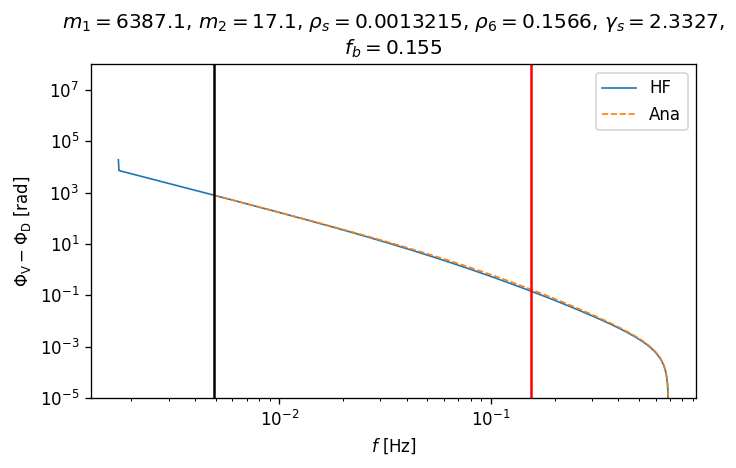

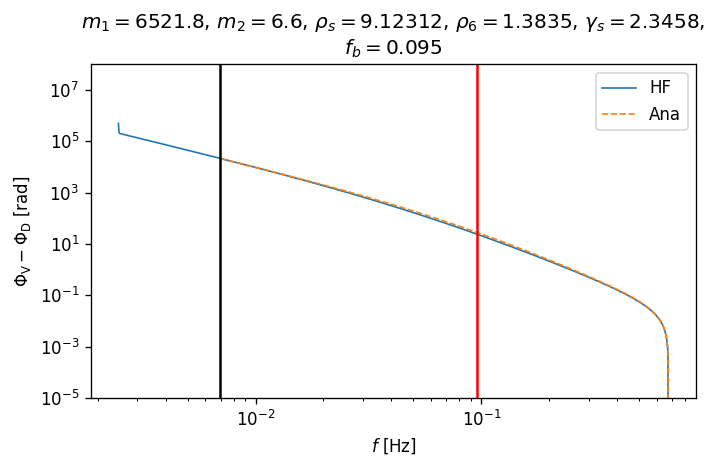

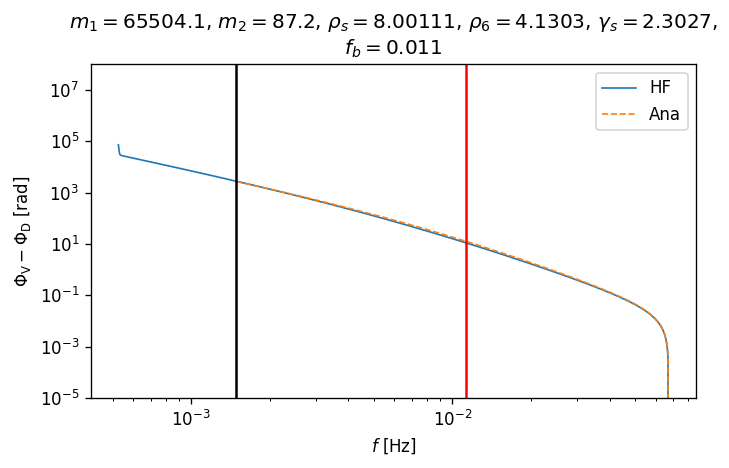

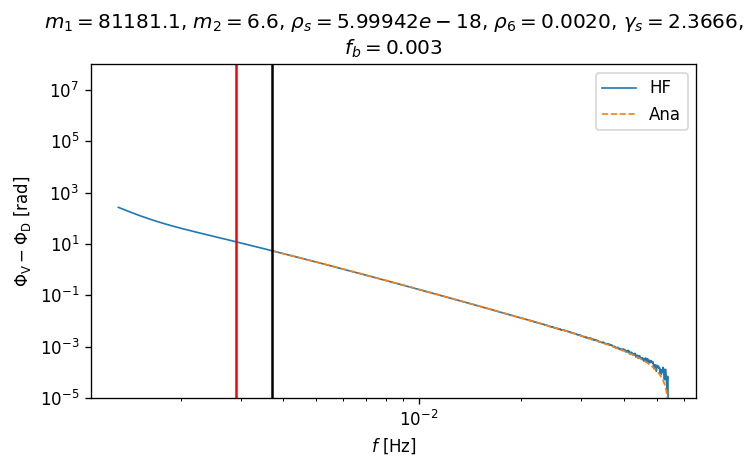

In [27]:
all_fits = []
for run in tqdm(runs):
    try:
        all_fits.append(main(run, f"fit_plots/dPhi-{run.id_str}.png"))
        print("\n")
    except Exception as e:
        print(f"Run {run} failed:", e, "\n")
        all_fits.append(None)

Bad runs: `f_b < f(t = 5 yr)`
- `M1_26564.3_M2_1.2_rho6_1.0308_gamma_2.2996`
- `M1_49668.8_M2_4.0_rho6_4.2337_gamma_2.2513`
- `M1_81181.1_M2_6.6_rho6_0.0020_gamma_2.3666`

In [52]:
# Remove bad runs
bad_ids = [
    "M1_26564.3_M2_1.2_rho6_1.0308_gamma_2.2996",
    "M1_49668.8_M2_4.0_rho6_4.2337_gamma_2.2513",
    "M1_81181.1_M2_6.6_rho6_0.0020_gamma_2.3666"
]

results = defaultdict(lambda: [])

for run, fit in zip(runs, all_fits):
    if "_rho1_" not in run.id_str and fit.id_str not in bad_ids:
        for k, v in fit._asdict().items():
            if k != "id_str":
                results[k].append(v)

results = dict(results)

jnp.savez("fb_fits.npz", **results)